In [339]:
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
import napari

In [340]:
from skimage import data
from tifffile import tifffile
from os.path import sep
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import pandas as pd
import seaborn as sns
import json
import os

In [394]:
#Generate data directory
#rootDir= 'For_testing'
#dataDir = sep.join([rootDir,'raw','60D05_GCaMP8M_PB_Pilot'])
#dataDir_sep = dataDir.split("/")
#motionCorrectedDir= sep.join([rootDir,'motionCorrected',sep.join(dataDir_sep[-1:])])

In [3]:
#Just used for reading single tiff file
image = tifffile.imread("/home/tianhaoqiu/Documents/GitHub/2p_analysis/combine_TSeries-60D05-GCaMP8s-07292022-1157-317.tiff")
print(image.shape)

(1216, 13, 104, 813)


In [341]:
#Some key parameters for imaging analysis (for futuure should come from direct reading of metadata file)
volume_cycle = 859
volume_time = 0.13979
volume_rate = 1/volume_time
slice_per_volume = 9
fictrack_sampling_rate = 200000

In [342]:
time_array_imaging = np.arange(volume_cycle)/volume_rate

In [343]:
def combine_single_tiff(slice_num, cycle_num, file_dir):
    #Create a list for the directory of every single ome-tiff file of the selected trial
    import tifftools
    tiff_files_li = []
    for ti in os.listdir(file_dir):
        if '.ome.tif' and 'Ch2' in ti:
            tiff_files_li.append(sep.join([file_dir, ti]))
    tiff_files_li.sort()
    
    #Find the size of a single image
    single_image_x = plt.imread(tiff_files_li[0]).shape[0]
    single_image_y = plt.imread(tiff_files_li[0]).shape[1]
    #Create the combined image array with the right size
    image_combi = np.zeros([cycle_num, slice_num, single_image_x,single_image_y])
    count = 0
    for current_cycle in range(cycle_num):
        for current_slice in range(slice_num):
            image_combi[current_cycle, current_slice] = plt.imread(tiff_files_li[count])
            count = count + 1
    
    
    return image_combi, tiff_files_li

In [344]:
image_data_combined, tiff_file_sequence = combine_single_tiff(slice_num = slice_per_volume, cycle_num = volume_cycle, file_dir = '/home/tianhaoqiu/Desktop/TSeries-11032022-1411-003')
image = image_data_combined
image.shape

(859, 9, 212, 398)

In [345]:
from tifffile import imsave
imsave('combine_TSeries-60D05-GCaMP8m-TSeries-11032022-1411-003.tiff',image)

In [346]:
# Write a low pass filter function for filtering imaging/heading data (same idea as written by YF)
def low_pass_filter_TQ(data, lowPassCutoff, sampleRate):
#   Inputs
#   data - trace to be filtered 
#   lowPassCutOff - value (Hz) that willbe the top limit of the filter
#   sampleRate- rate data is sampled at to allow correcrt conversion in to Hz
#   Outpput: filtered version of the data
#   Tianhao Qiu  10/2022

# build a butter function
    from scipy.signal import butter, filtfilt
    [b,a] = butter(1, lowPassCutoff / (sampleRate/2), 'lowpass')
#Filter data using butter function *(axis,padtype padlen set to be exactly same as Matlab filtfilt function)    
    out =filtfilt(b,a, data, axis = 0,padtype = 'odd', padlen=3*(max(len(b),len(a))-1))
    
    return out 

In [117]:
viewer = napari.Viewer()
new_layer = viewer.add_image(image)
#viewer.dims.ndisplay = 3

In [347]:
imgStack = xr.DataArray(image,dims = ['volumes [s]', 'planes [µm]', 'xpix [µm]', 'ypix [µm]'])

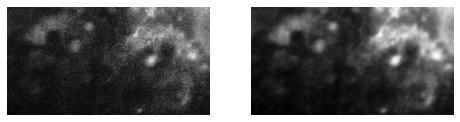

In [348]:
## Motion Correction setup
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume
# Generate reference image
reference_num = np.int_(np.round(0.1 * volume_cycle))
refImg = np.mean(stackMP[0:reference_num,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');


In [349]:
def computeMotionShift(stack, refImage, upsampleFactor, sigmaval = 2, doFilter = False, stdFactor = 2, showShiftFig = True):
    from skimage.registration import phase_cross_correlation

    if len(refImage.shape) == 3:
        print('perform motion correction on a volume')
        refImgFilt = refImage.copy()
        for p in range(stack['planes [µm]'].size):
            refImgFilt[p,:,:] = gaussian_filter(refImage[p,:,:], sigma=sigmaval)
        shift = np.zeros((2, stack['planes [µm]'].size,stack['volumes [s]'].size))
        error = np.zeros((stack['planes [µm]'].size,stack['volumes [s]'].size))
        diffphase = np.zeros((stack['planes [µm]'].size,stack['volumes [s]'].size))
    else:
        print('perform motion correction on a single plane/max projection')
        refImgFilt = gaussian_filter(refImage, sigma=sigmaval)

        shift = np.zeros((2, stack['volumes [s]'].size))
        error = np.zeros(stack['volumes [s]'].size)
        diffphase = np.zeros(stack['volumes [s]'].size)

    # compute shift
    for i in range(stack['volumes [s]'].size):
        if len(refImage.shape) == 3:
            for p in range(stack['planes [µm]'].size):
                shifImg = stack[i,p,:,:]
                shifImgFilt = gaussian_filter(shifImg, sigma=sigmaval)

                # compute shift
                shift[:,p,i], error[p,i], diffphase[p,i] = phase_cross_correlation(refImgFilt[p,:,:].data, shifImgFilt,
                                                                             upsample_factor = upsampleFactor)
        else:
            shifImg = stack[i,:,:]
            shifImgFilt = gaussian_filter(shifImg, sigma=sigmaval)

            # compute shift
            shift[:,i], error[i], diffphase[i] = phase_cross_correlation(refImgFilt, shifImgFilt,
                                                                         upsample_factor = upsampleFactor)
    if showShiftFig:
        if len(refImage.shape) == 3:
            fig, axs = plt.subplots(2,1,figsize=(15,6))
            axlab = ['x','y']
            for i, ax in enumerate(axs):
                ax.plot(shift[i,:].T)
                ax.set_xlabel('frames')
                ax.set_ylabel('image shift for {}'.format(axlab[i]))
        else:
            fig, ax = plt.subplots(1,1,figsize=(15,5))
            ax.plot(shift[0,:])
            ax.plot(shift[1,:])
            ax.set_xlabel('frames')
            ax.set_ylabel('image shift/pixel')

    if doFilter:
        shiftFilt_x = shift[0,:].copy()
        shiftFilt_y = shift[1,:].copy()
        shiftFilt_x[abs(shiftFilt_x) > stdFactor*np.std(shiftFilt_x)] = np.nan
        shiftFilt_y[abs(shiftFilt_y) > stdFactor*np.std(shiftFilt_y)] = np.nan

        allT = np.arange(len(shiftFilt_x))
        shiftFilt_x_interp = np.interp(allT, allT[~np.isnan(shiftFilt_x)], shiftFilt_x[~np.isnan(shiftFilt_x)])
        shiftFilt_y_interp = np.interp(allT, allT[~np.isnan(shiftFilt_y)], shiftFilt_y[~np.isnan(shiftFilt_y)])

        if showShiftFig:
            ax.plot(shiftFilt_x_interp,'b')
            ax.plot(shiftFilt_y_interp,'c')

        return np.vstack((shiftFilt_x_interp,shiftFilt_y_interp))
    else:
        return shift



perform motion correction on a single plane/max projection


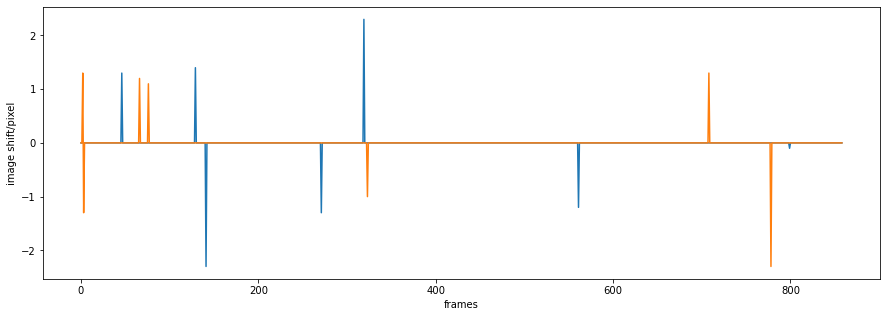

In [350]:
shift = computeMotionShift(stackMP, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)

In [351]:
def motionCorrection(stack, shift):
    from scipy.ndimage import shift as spshift

    #check if shift was calculated for each plane in a volume separately, then check if stack to be aligned is 3d or 4d

    #stack should be an xarray
    stackMC = stack.copy()

    if len(shift.shape) == 3:
        # separate shifts for each plane in a volume
        if len(stack.shape) < 4:
            print("Imaging stack needs to be 4D.")
            return np.nan*stackMC
        for p in range(stack['planes [µm]'].size):
            for i in range(stack['volumes [s]'].size):
                shifImg = stack[i,p,:,:]
                stackMC[i,p,:,:] = spshift(shifImg, shift[:,p,i], order=1,mode='reflect')

    else:
        #one shift per volume per time point
        if len(stack.shape) < 4:
            # motion correction on single plane or max projection
            for i in range(stack['volumes [s]'].size):
                shifImg = stack[i,:,:]
                stackMC[i,:,:] = spshift(shifImg, shift[:,i], order=1,mode='reflect')
        else:
            #motion correction of 4D stack
            for v in range(stack["volumes [s]"].size):  #move one volume at a time
                tmpVol = stack[{"volumes [s]": v}]
                for p in range(tmpVol["planes [µm]"].size):
                    stackMC[v,p,:,:]  = spshift(tmpVol[p,:,:], shift[:,v], order=1,mode='reflect')

    return stackMC

In [352]:
stack4dMC = motionCorrection(imgStack, shift)

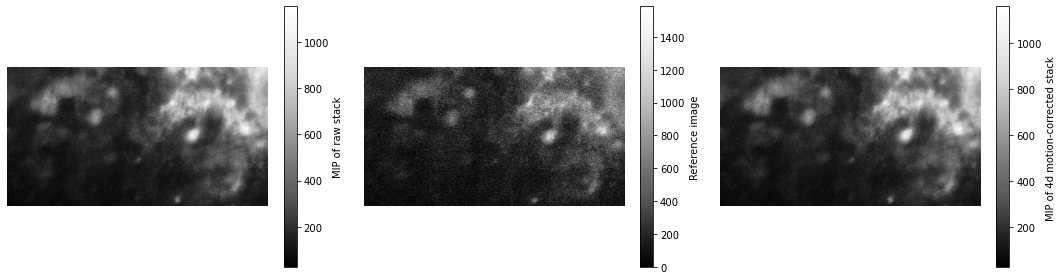

In [353]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
cb = axs[0].imshow(imgStack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

In [20]:
#new_layer = viewer.add_image(image[:,4,:,:])

In [21]:
#viewer.layers.save('my_file.csv')

In [354]:
stack4dMC.shape

(859, 9, 212, 398)

In [355]:
label = tifffile.imread("/home/tianhaoqiu/Documents/GitHub/2p_analysis/ROI_16-60D05-GCaMP8m-TSeries-11032022-1411-003.tif")
#viewer.add_labels(label, name='Labels_16_Roi')

In [356]:
#Load ROI and label from napari
#napari_roi_16 = viewer.layers['Labels_16_Roi'].data
napari_roi_16 = label[0,:,:,:]

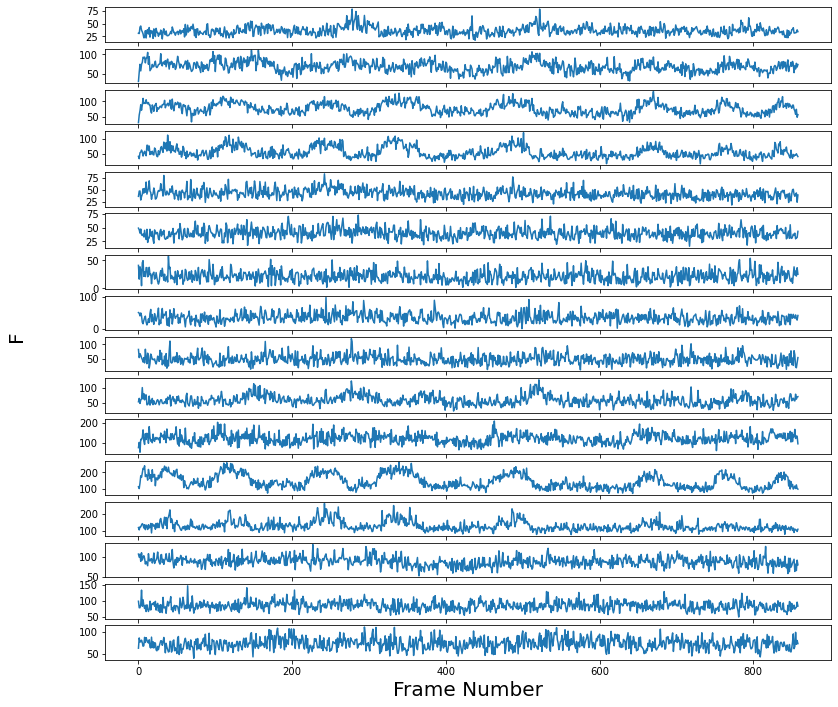

In [357]:
ROI_number = 16
F_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
stack4dMC_numpy = stack4dMC.to_numpy()
for time_point in range(stack4dMC['volumes [s]'].size):
        current_volume = stack4dMC_numpy[time_point,:,:,:]
        for ROI_index in range(1, ROI_number + 1):
            mask = napari_roi_16 == ROI_index
            F_array[time_point, ROI_index - 1] =current_volume[mask].mean() 
            
fig, axs = plt.subplots(ROI_number, 1, figsize=(13, 12))
for i in range(ROI_number):
    ax = axs[i]
    ax.plot(F_array[:,i])
fig.supylabel('F',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()
    

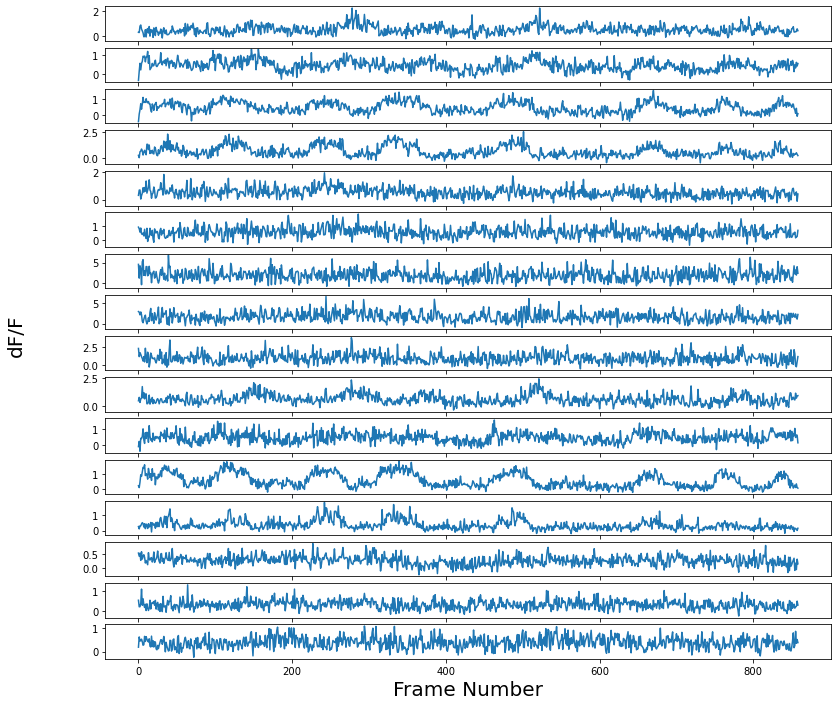

In [358]:
dF_F_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
F_zero = np.quantile(F_array, 0.05, axis = 0)
for F_zero_index in range(ROI_number):
    dF_F_array[:,F_zero_index] = (F_array[:,F_zero_index] - F_zero[F_zero_index])/F_zero[F_zero_index]



fig, axs = plt.subplots(ROI_number, 1, figsize=(13, 12))
for i in range(ROI_number):
    ax = axs[i]
    ax.plot(dF_F_array[:,i])
fig.supylabel('dF/F',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

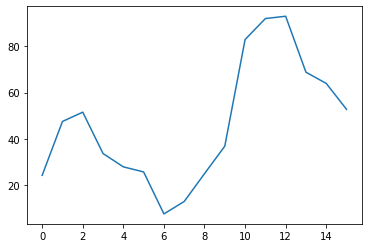

In [359]:
plt.plot(F_zero)

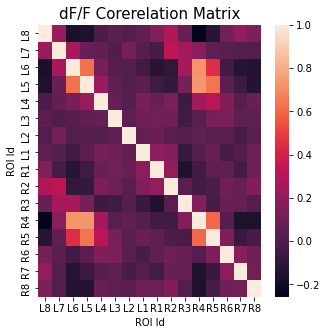

In [360]:
#Create a correlation matrix to look at the correlation between corresponding golemuruli in left/right PB
df_f_dataframe = pd.DataFrame(dF_F_array, columns=['L8', 'L7', 'L6','L5','L4','L3','L2','L1','R1','R2','R3','R4','R5','R6','R7','R8'])
correlation_matrix_df_f = df_f_dataframe.corr()
plt.figure(figsize= (5,5))
sns.heatmap(correlation_matrix_df_f)
plt.xlabel('ROI Id', fontsize=10)
plt.ylabel('ROI Id', fontsize=10)
plt.title('dF/F Corerelation Matrix', fontsize=15)
plt.show()

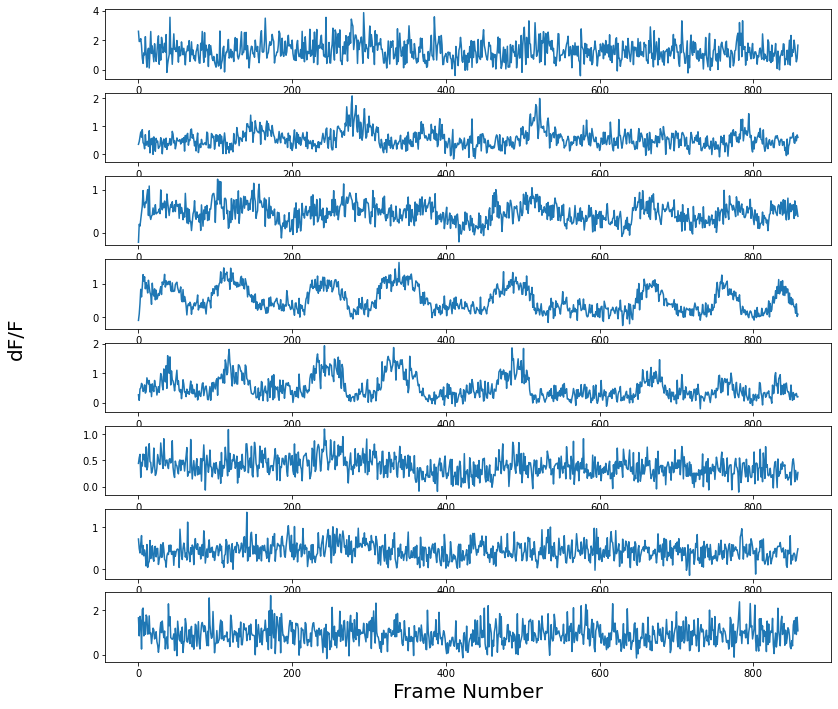

In [361]:
#Combine corresponding glomeruli in left and right PBs, leaving 8 ROIs for calculating PVA
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)

ROI_number_combined = 8
dF_F_array_8_roi = np.zeros((stack4dMC['volumes [s]'].size, ROI_number_combined))
for combined_ROI_index in range(ROI_number_combined):
    if combined_ROI_index == ROI_number_combined - 1:
        #Count pixel number to determine the weight of glomeruli L1 & R1 (And put it at first)
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 1)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        #Put it at first
        dF_F_array_8_roi[:,0] = dF_F_array[:,combined_ROI_index] * left_weight +  dF_F_array[:,combined_ROI_index + 1] * right_weight
    else:
        #Count pixel number to determine the weight of the rest of each glomeruli 
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 9)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        dF_F_array_8_roi[:,combined_ROI_index + 1] = dF_F_array[:,combined_ROI_index] * left_weight +  dF_F_array[:,combined_ROI_index + 9] * right_weight
        


fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(dF_F_array_8_roi[:,i])
fig.supylabel('dF/F',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

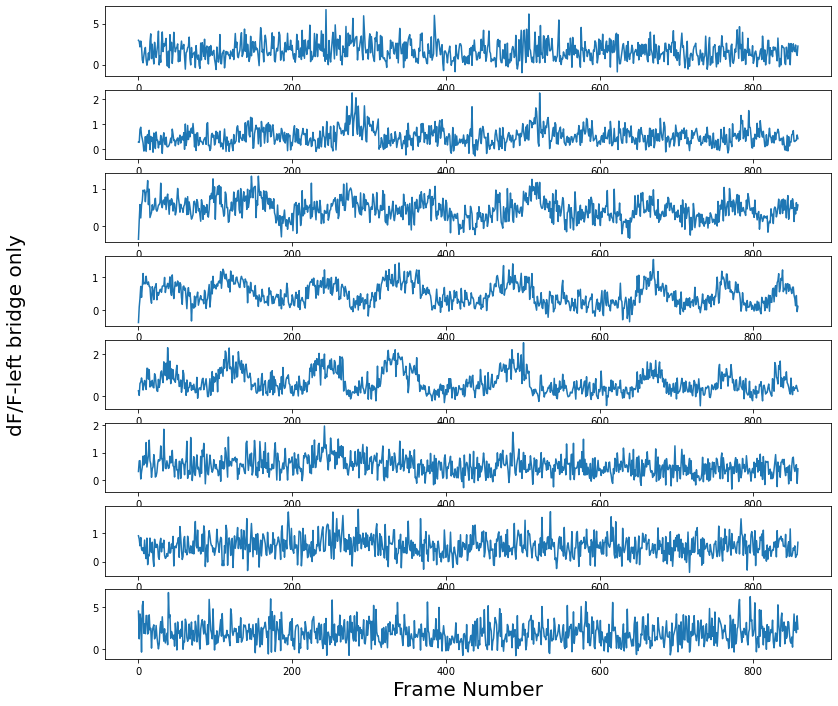

In [362]:
#dF/F For left bridge only (have seen left bridge have stronger signals in general many times) 

ROI_number_combined = 8
dF_F_8_roi_left_only = np.zeros((stack4dMC['volumes [s]'].size, ROI_number_combined))
dF_F_8_roi_left_only[:,0] = dF_F_array[:,7]
for j in range(ROI_number_combined-1):
    dF_F_8_roi_left_only[:,j+1] = dF_F_array[:,j]
    

fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(dF_F_8_roi_left_only[:,i])
fig.supylabel('dF/F-left bridge only',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

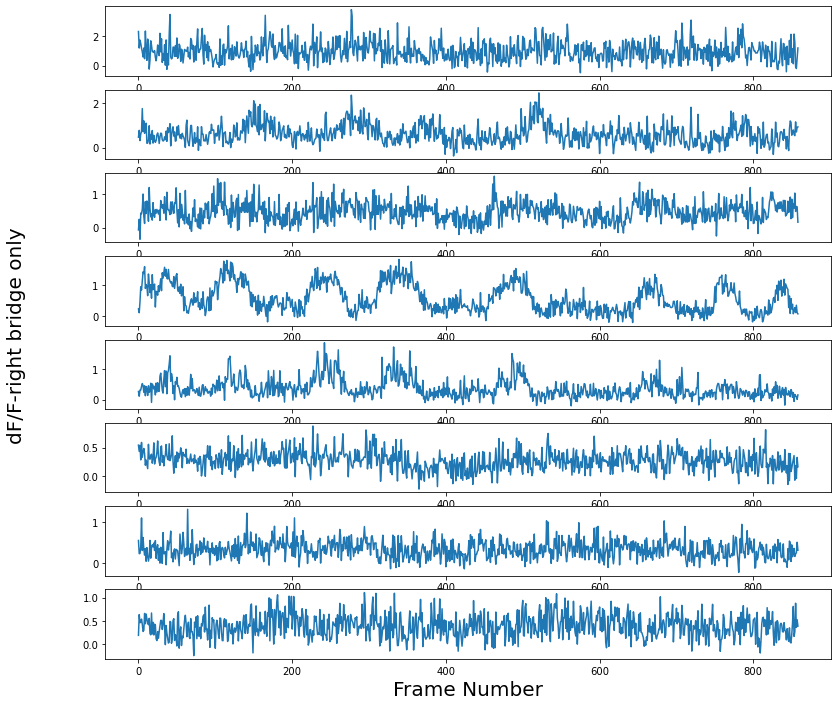

In [415]:
#dF/F For right bridge only (for comparison) 
ROI_number_combined = 8
dF_F_8_roi_right_only = np.zeros((stack4dMC['volumes [s]'].size, ROI_number_combined))
for j in range(ROI_number_combined):
    dF_F_8_roi_right_only[:,j] = dF_F_array[:,8+j]
    
    
fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(dF_F_8_roi_right_only[:,i])
fig.supylabel('dF/F-right bridge only',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

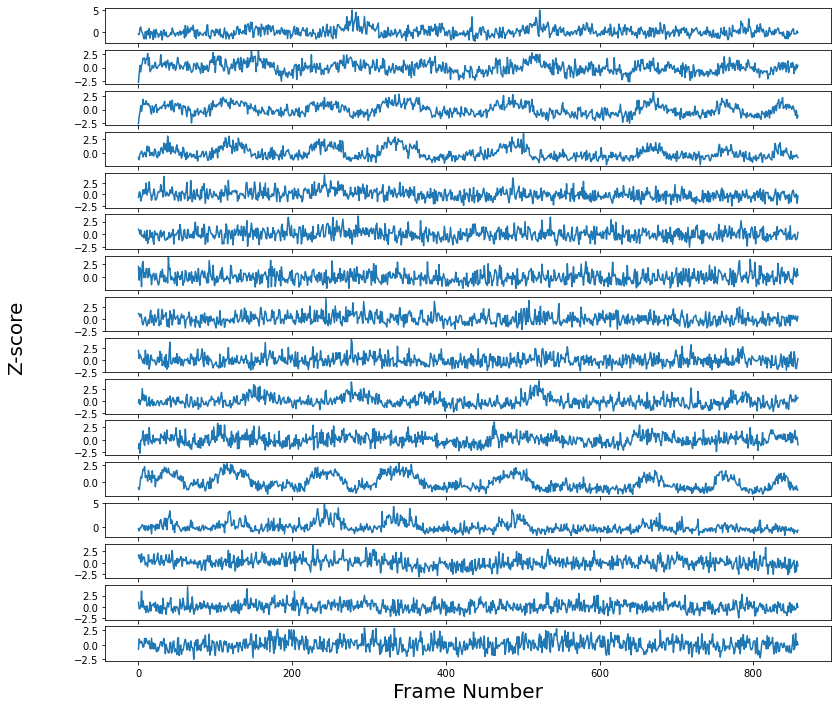

In [366]:
# Z-score: alternative way to calculate df/f
Z_score_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
F_sd = np.std(F_array, axis = 0)
F_mean = np.mean(F_array, axis = 0)
for z_index in range(ROI_number):
    Z_score_array [:,z_index] = (F_array[:,z_index] - F_mean[z_index])/F_sd[z_index]



fig, axs = plt.subplots(ROI_number, 1, figsize=(13, 12))
for i in range(ROI_number):
    ax = axs[i]
    ax.plot(Z_score_array [:,i])
fig.supylabel('Z-score',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

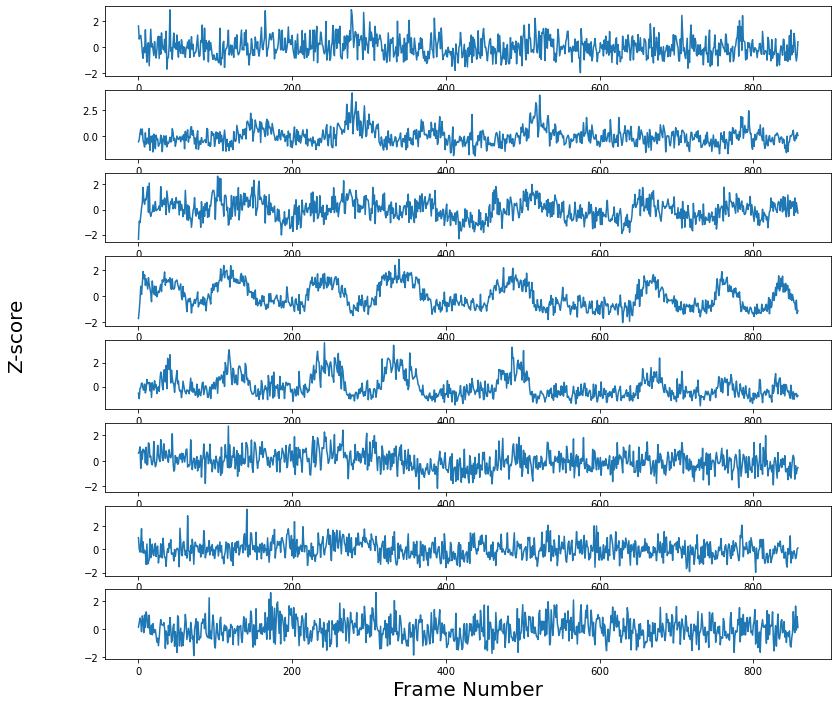

In [367]:
#Combine corresponding glomeruli in left and right PBs, leaving 8 ROIs for calculating PVA
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)

ROI_number_combined = 8
z_8_roi = np.zeros((stack4dMC['volumes [s]'].size, ROI_number_combined))
for combined_ROI_index in range(ROI_number_combined):
    if combined_ROI_index == ROI_number_combined - 1:
        #Count pixel number to determine the weight of glomeruli L1 & R1 (And put it at first)
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 1)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        #Put it at first
        z_8_roi[:,0] = Z_score_array[:,combined_ROI_index] * left_weight +  Z_score_array[:,combined_ROI_index + 1] * right_weight
    else:
        #Count pixel number to determine the weight of the rest of each glomeruli 
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 9)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        z_8_roi[:,combined_ROI_index + 1] = Z_score_array[:,combined_ROI_index] * left_weight +  Z_score_array[:,combined_ROI_index + 9] * right_weight
        


fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(z_8_roi[:,i])
fig.supylabel('Z-score',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

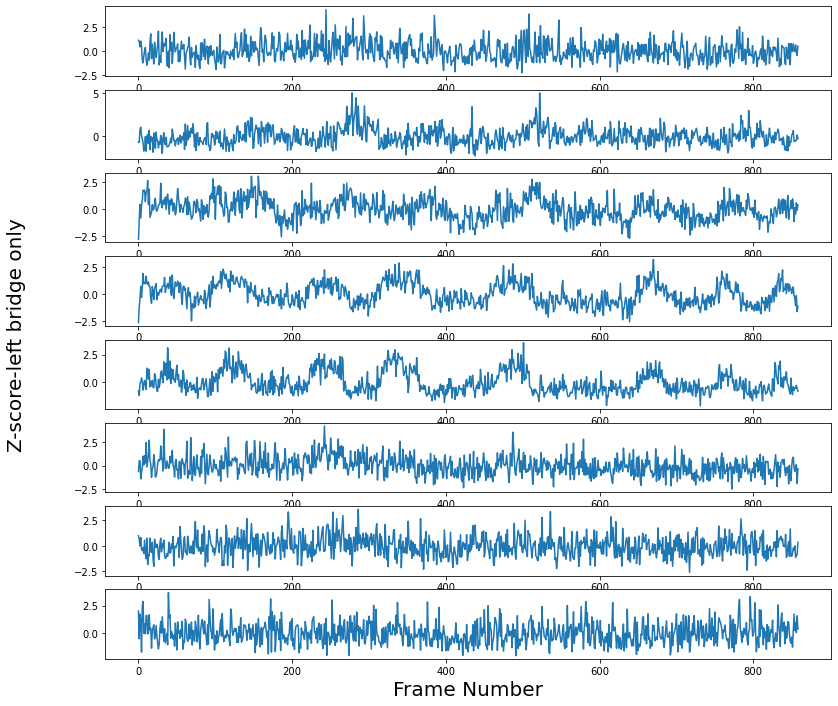

In [368]:
#Combine corresponding glomeruli in left PBs only
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)

ROI_number_combined = 8
z_8_roi_left_only = np.zeros((stack4dMC['volumes [s]'].size, ROI_number_combined))
z_8_roi_left_only[:,0] = Z_score_array[:,7]
for j in range(ROI_number_combined-1):
    z_8_roi_left_only[:,j+1] = Z_score_array[:,j]
    

fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(z_8_roi_left_only[:,i])
fig.supylabel('Z-score-left bridge only',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

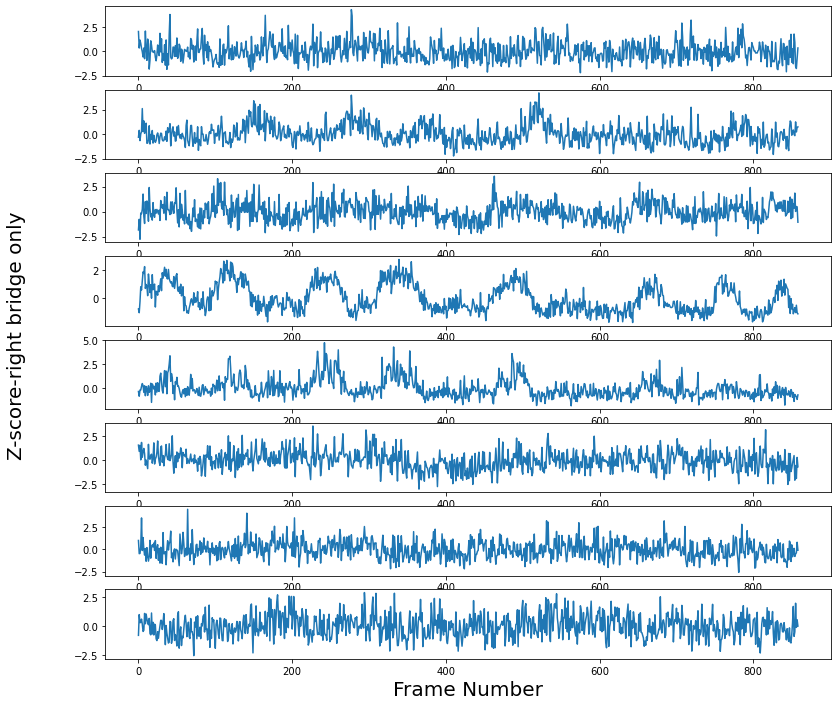

In [418]:
#Combine corresponding glomeruli in right PBs only
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)

ROI_number_combined = 8
z_8_roi_right_only = np.zeros((stack4dMC['volumes [s]'].size, ROI_number_combined))
for j in range(ROI_number_combined):
    z_8_roi_right_only[:,j] = Z_score_array[:,8+j]
    

fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(z_8_roi_right_only[:,i])
fig.supylabel('Z-score-right bridge only',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

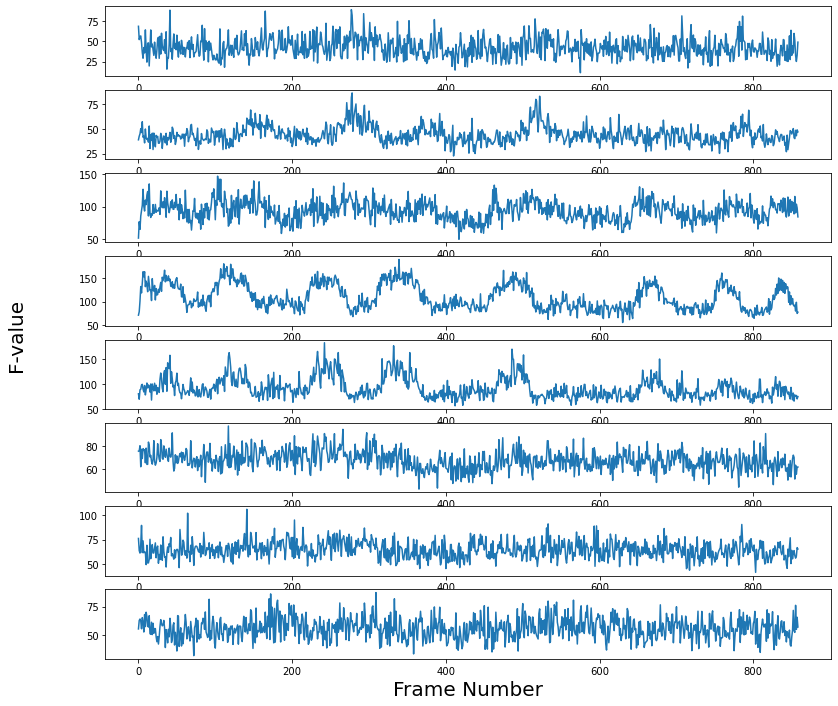

In [369]:
#Combine corresponding glomeruli in left and right PBs, leaving 8 ROIs for calculating PVA
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)

ROI_number_combined = 8
F_8_roi = np.zeros((stack4dMC['volumes [s]'].size, ROI_number_combined))
for combined_ROI_index in range(ROI_number_combined):
    if combined_ROI_index == ROI_number_combined - 1:
        #Count pixel number to determine the weight of glomeruli L1 & R1 (And put it at first)
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 1)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        #Put it at first
        F_8_roi[:,0] = F_array[:,combined_ROI_index] * left_weight +  F_array[:,combined_ROI_index + 1] * right_weight
    else:
        #Count pixel number to determine the weight of the rest of each glomeruli 
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 9)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        F_8_roi[:,combined_ROI_index + 1] = F_array[:,combined_ROI_index] * left_weight +  F_array[:,combined_ROI_index + 9] * right_weight
        


fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(F_8_roi[:,i])
fig.supylabel('F-value',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

In [370]:
#Calculate PVA
def PVA_radian_calcul (dff_array, frame_number, ROI_NUM):
    #Assign an angle-array for 8 ROIs ROI1(1R/1L)is0,  ROI2(2R/8L) is 45
    #angle_array_roi_8 = [0,np.pi/4,np.pi/2,np.pi*3/4,np.pi,np.pi*5/4,np.pi*3/2,np.pi*7/4]
    angle_array_roi_8 = [np.pi/8,np.pi*3/8,np.pi*5/8,np.pi*7/8,np.pi*9/8,np.pi*11/8,np.pi*13/8,np.pi*15/8]
    #Define a polar 2 cartesian function 
    def pol2cart(rho, phi):
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        return x, y
    #Initialize PVA_array 
    PVA_radianArray = np.zeros(frame_number)
    
    for current_PVA_index in range(len(dff_array)):
        temp_x= np.zeros(ROI_NUM)
        temp_y= np.zeros(ROI_NUM)
        for current_ROI_index in range(ROI_NUM):
            temp_x[current_ROI_index], temp_y[current_ROI_index] = pol2cart(dff_array[current_PVA_index,current_ROI_index],angle_array_roi_8[current_ROI_index])
            x_value_PVA = sum(temp_x)
            y_value_PVA = sum(temp_y)
            PVA_radianArray[current_PVA_index] = np.arctan2(y_value_PVA , x_value_PVA )
    
    return PVA_radianArray

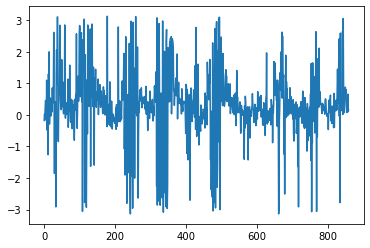

In [371]:
PVA_radian_array = PVA_radian_calcul(dF_F_array_8_roi, stack4dMC['volumes [s]'].size,ROI_number_combined)
plt.plot(PVA_radian_array)

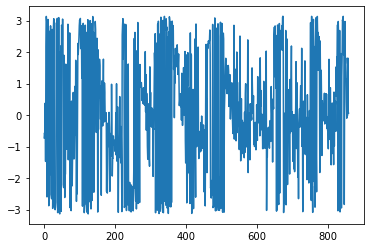

In [372]:
PVA_radian_array_z = PVA_radian_calcul(z_8_roi, stack4dMC['volumes [s]'].size,ROI_number_combined)
plt.plot(PVA_radian_array_z)

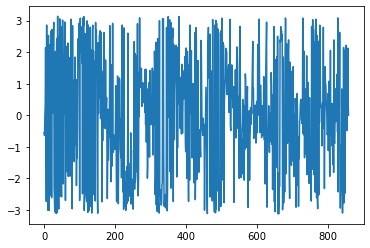

In [373]:
PVA_radian_array_z_left_only = PVA_radian_calcul(z_8_roi_left_only, stack4dMC['volumes [s]'].size,ROI_number_combined)
plt.plot(PVA_radian_array_z_left_only)

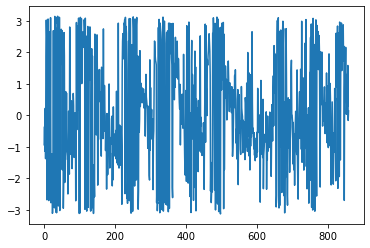

In [424]:
PVA_radian_array_z_right_only = PVA_radian_calcul(z_8_roi_right_only, stack4dMC['volumes [s]'].size,ROI_number_combined)
plt.plot(PVA_radian_array_z_right_only)

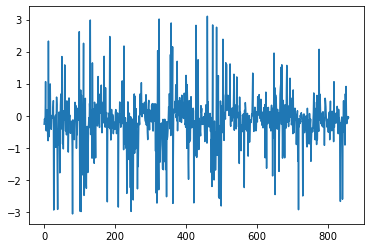

In [425]:
PVA_radian_array_dff_left_only = PVA_radian_calcul(dF_F_8_roi_left_only, stack4dMC['volumes [s]'].size,ROI_number_combined)
plt.plot(PVA_radian_array_dff_left_only)

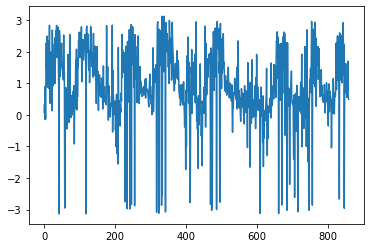

In [420]:
PVA_radian_array_dff_right_only = PVA_radian_calcul(dF_F_8_roi_right_only, stack4dMC['volumes [s]'].size,ROI_number_combined)
plt.plot(PVA_radian_array_dff_right_only)

In [421]:
import math
def PVA_radian_to_angle(PVA_radian):
    PVA_angle = np.zeros(PVA_radian.size)
    for current_frame in range(len(PVA_radian)):
        if PVA_radian[current_frame] >= 0:
            PVA_angle[current_frame] = math.degrees(PVA_radian[current_frame])
        else:
            PVA_angle[current_frame] = 360 + math.degrees(PVA_radian[current_frame])
    return PVA_angle

In [426]:
PVA_angle_Array = PVA_radian_to_angle(PVA_radian_array)
PVA_angle_Array_z = PVA_radian_to_angle(PVA_radian_array_z)
PVA_angle_Array_z_left_only = PVA_radian_to_angle(PVA_radian_array_z_left_only)
PVA_angle_Array_dff_left_only = PVA_radian_to_angle(PVA_radian_array_dff_left_only)
PVA_angle_Array_z_right_only = PVA_radian_to_angle(PVA_radian_array_z_right_only)
PVA_angle_Array_dff_right_only = PVA_radian_to_angle(PVA_radian_array_dff_right_only)

In [379]:
def PVAangleToRoi (PVA_angle):
    PVA_ROI = np.zeros(PVA_angle.size)
    for current_frame in range(len(PVA_angle)):
        if 0 <= PVA_angle[current_frame] < 45:
            PVA_ROI[current_frame] = 0
        elif 45 <= PVA_angle[current_frame] < 90:
            PVA_ROI[current_frame] = 1
        elif 90 <= PVA_angle[current_frame] < 135:
            PVA_ROI[current_frame] = 2
        elif 135 <= PVA_angle[current_frame] < 180:
            PVA_ROI[current_frame] = 3
        elif 180 <= PVA_angle[current_frame] < 225:
            PVA_ROI[current_frame] = 4
        elif 225 <= PVA_angle[current_frame] < 270:
            PVA_ROI[current_frame] = 5
        elif 270 <= PVA_angle[current_frame] < 315:
            PVA_ROI[current_frame] = 6
        else:
            PVA_ROI[current_frame] = 7
            
    return PVA_ROI

In [427]:
PVA_ROI_assigned = PVAangleToRoi(PVA_angle_Array)
PVA_ROI_assigned_z = PVAangleToRoi(PVA_angle_Array_z)
PVA_ROI_assigned_z_left_only = PVAangleToRoi(PVA_angle_Array_z_left_only)
PVA_ROI_assigned_dff_left_only = PVAangleToRoi(PVA_angle_Array_dff_left_only)
PVA_ROI_assigned_dff_right_only = PVAangleToRoi(PVA_angle_Array_dff_right_only)
PVA_ROI_assigned_z_right_only = PVAangleToRoi(PVA_angle_Array_z_right_only)

In [428]:
#Calculate real-time bumop amplitude baased on method in Fisher, Marquis et al. 2022 
def calcualteBumpAmplitude (signal_array):
    amplitude_array = np.zeros(len(dF_F_array_8_roi))
    for i in range(len(dF_F_array_8_roi)):
        max_signal = np.max(signal_array[i,:])
        min_signal = np.min(signal_array[i,:])
        amplitude_array[i] = max_signal - min_signal
    return amplitude_array

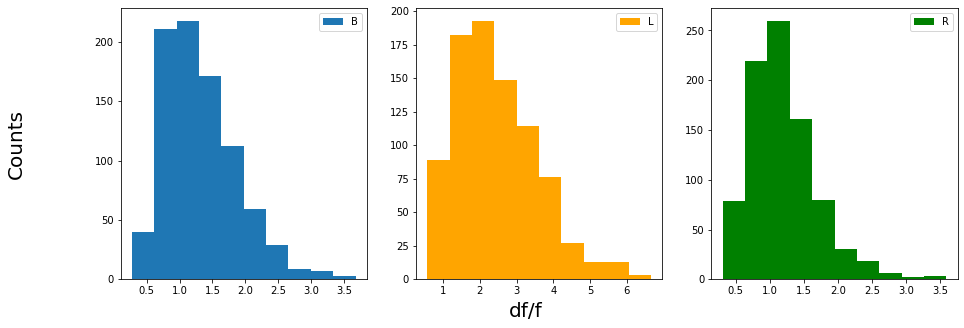

In [490]:
bump_amplitude_dff = calcualteBumpAmplitude(dF_F_array_8_roi)
bump_amplitude_dff_left_only = calcualteBumpAmplitude(dF_F_8_roi_left_only) 
bump_amplitude_dff_right_only = calcualteBumpAmplitude(dF_F_8_roi_right_only)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ax = axs[0]
ax.hist(bump_amplitude_dff)
ax.legend('Both Bridges')

ax = axs[1]
ax.hist(bump_amplitude_dff_left_only, color = 'orange')
ax.legend('Left Bridge Only')

ax = axs[2]
ax.hist(bump_amplitude_dff_right_only, color = 'green')
ax.legend('Right Bridges Only')

fig.supylabel('Counts',fontsize=20)
fig.supxlabel('df/f', fontsize=20)
plt.show()

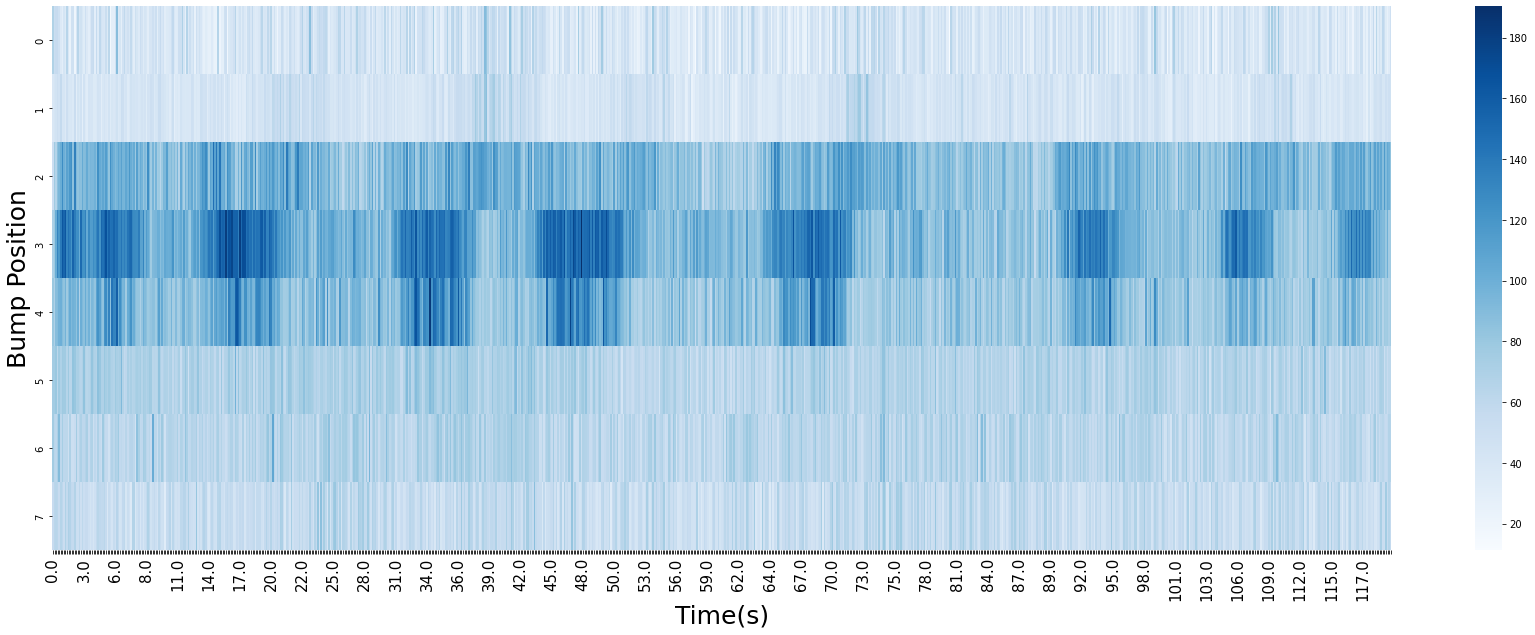

In [386]:
#Heatmap for raw F value
#Plot heatmap of signals in combined ROI and superimpose with PVA
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
F_in_ROI = pd.DataFrame(F_8_roi.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(F_in_ROI , cmap='Blues', xticklabels = time_array_imaging_round)
p1.set_xticklabels(p1.get_xticklabels(), size =15)
sns.color_palette("light:b", as_cmap=True)
for index, label in enumerate(p1.get_xticklabels()):
    if index % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

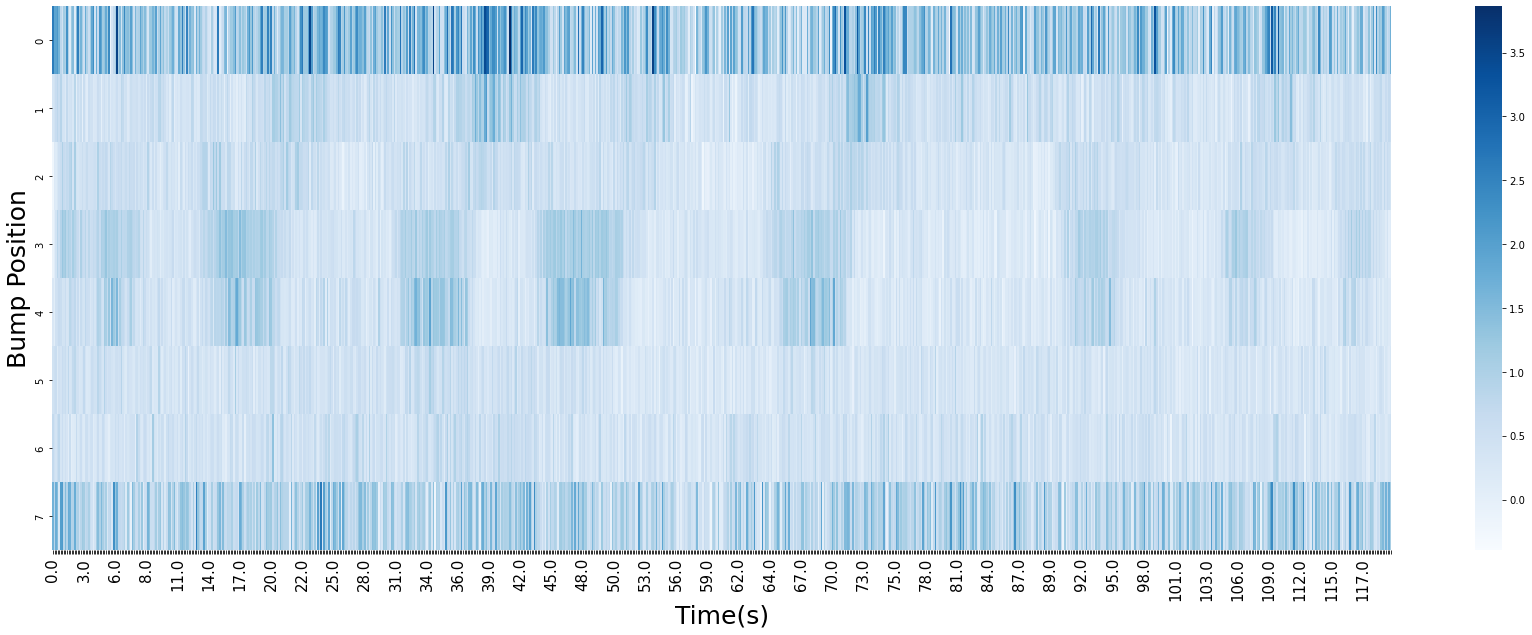

In [387]:
#Heatmap for dF/F value
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
df_dff_in_ROI = pd.DataFrame(dF_F_array_8_roi.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(df_dff_in_ROI , cmap='Blues', xticklabels = time_array_imaging_round)
p1.set_xticklabels(p1.get_xticklabels(), size =15)
sns.color_palette("light:b", as_cmap=True)
for index, label in enumerate(p1.get_xticklabels()):
    if index % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

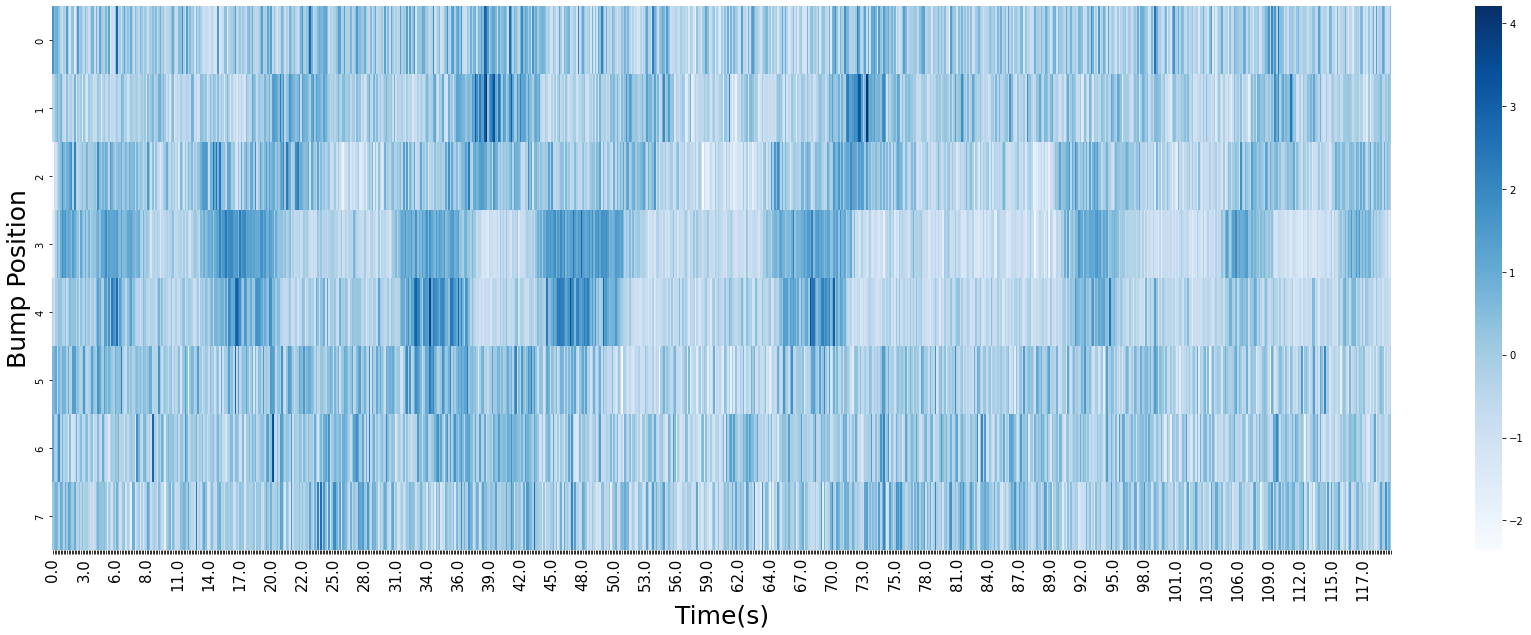

In [388]:
#Heatmap for Z score
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
z_in_ROI = pd.DataFrame(z_8_roi.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(z_in_ROI , cmap='Blues', xticklabels = time_array_imaging_round)
p1.set_xticklabels(p1.get_xticklabels(), size =15)
sns.color_palette("light:b", as_cmap=True)
for index, label in enumerate(p1.get_xticklabels()):
    if index % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

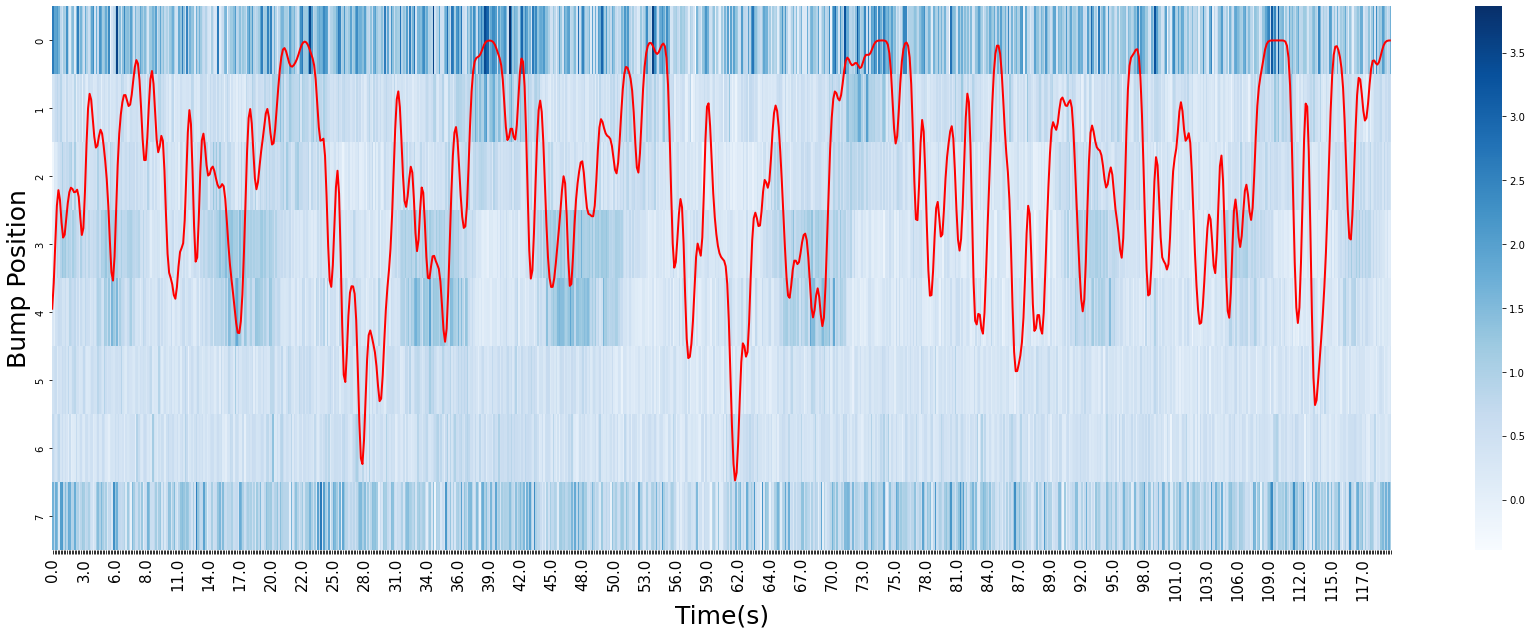

In [389]:
#Plot heatmap of signals in combined ROI and superimpose with PVA
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
df_dff_in_ROI = pd.DataFrame(dF_F_array_8_roi.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(df_dff_in_ROI , cmap='Blues', xticklabels = time_array_imaging_round)
p1.set_xticklabels(p1.get_xticklabels(), size =15)
sns.color_palette("light:b", as_cmap=True)
for index, label in enumerate(p1.get_xticklabels()):
    if index % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
# + 0.5 to put the PVA line in the middle
#p2 = sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned, sigma = 2)+0.5, color='red', linewidth =2)
#p2 = sns.lineplot(data = low_pass_filter_TQ(PVA_ROI_assigned, lowPassCutoff = 0.5, sampleRate = volume_rate )+0.5, color='red', linewidth =2)
#plt.plot(PVA_ROI_assigned+0.5,color='red', linewidth =2)
sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned, sigma = 2)+0.5, color='red', linewidth =2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

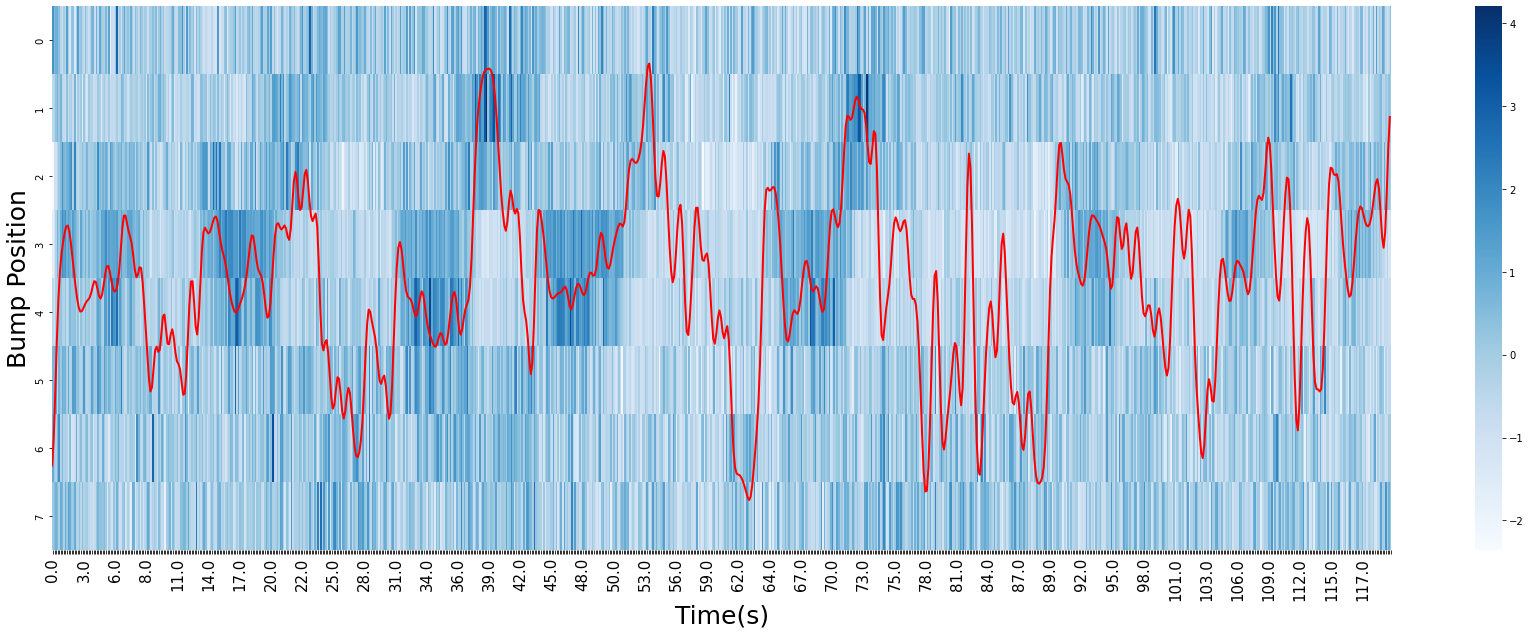

In [390]:
#Plot heatmap of z-scored signals in combined ROI and superimpose with PVA
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
z_in_ROI = pd.DataFrame(z_8_roi.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(z_in_ROI , cmap='Blues', xticklabels = time_array_imaging_round)
p1.set_xticklabels(p1.get_xticklabels(), size =15)
sns.color_palette("light:b", as_cmap=True)
for index, label in enumerate(p1.get_xticklabels()):
    if index % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
# + 0.5 to put the PVA line in the middle
#p2 = sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_z, sigma = 2)+0.5, color='red', linewidth =2)
#p2 = sns.lineplot(data = low_pass_filter_TQ(PVA_ROI_assigned_z, lowPassCutoff = 0.5, sampleRate = volume_rate )+0.5, color='red', linewidth =2)
#plt.plot(PVA_ROI_assigned_z+0.5,color='red', linewidth =2)
sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_z, sigma = 2)+0.5, color='red', linewidth =2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

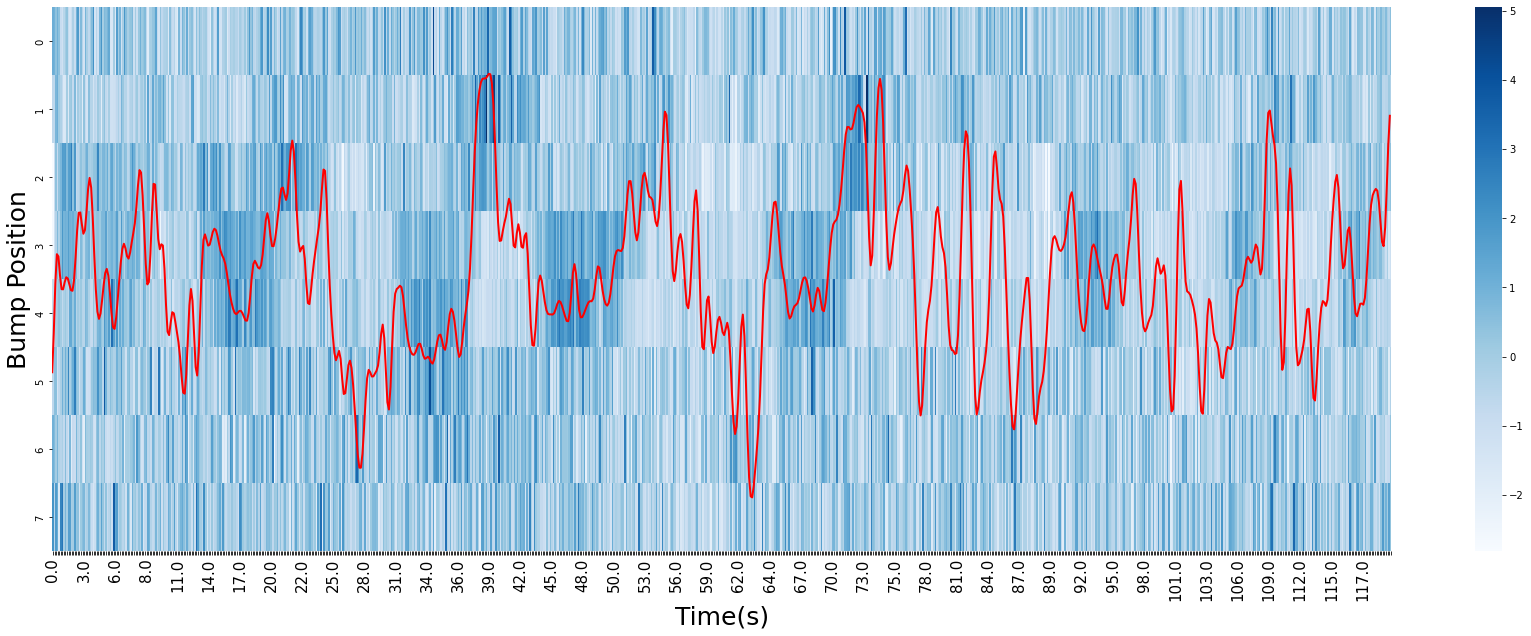

In [391]:
#Plot heatmap of signals in combined ROI and superimpose with PVA calculated from z score (left only)
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
z_in_ROI_left_only = pd.DataFrame(z_8_roi_left_only.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(z_in_ROI_left_only , cmap='Blues', xticklabels = time_array_imaging_round)
p1.set_xticklabels(p1.get_xticklabels(), size =15)
sns.color_palette("light:b", as_cmap=True)
for index, label in enumerate(p1.get_xticklabels()):
    if index % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
# + 0.5 to put the PVA line in the middle
#p2 = sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_z, sigma = 2)+0.5, color='red', linewidth =2)
#p2 = sns.lineplot(data = low_pass_filter_TQ(PVA_ROI_assigned_z, lowPassCutoff = 0.5, sampleRate = volume_rate )+0.5, color='red', linewidth =2)
#plt.plot(PVA_ROI_assigned_z+0.5,color='red', linewidth =2)
sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_z_left_only, sigma = 2)+0.5, color='red', linewidth =2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

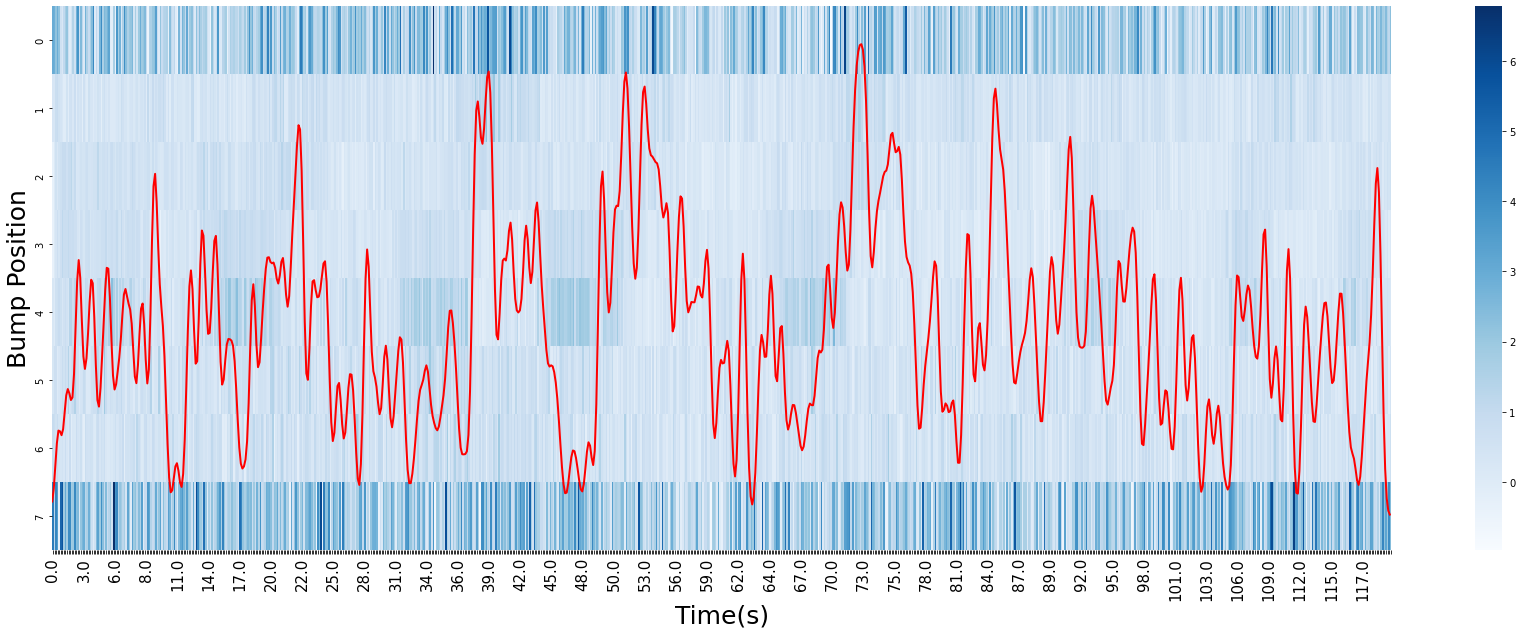

In [392]:
#Plot heatmap of signals in combined ROI and superimpose with PVA calculated from dff score (left only)
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
dF_F_in_ROI_left_only = pd.DataFrame(dF_F_8_roi_left_only.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(dF_F_in_ROI_left_only , cmap='Blues', xticklabels = time_array_imaging_round)
p1.set_xticklabels(p1.get_xticklabels(), size =15)
sns.color_palette("light:b", as_cmap=True)
for index, label in enumerate(p1.get_xticklabels()):
    if index % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
# + 0.5 to put the PVA line in the middle
#p2 = sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_z, sigma = 2)+0.5, color='red', linewidth =2)
#p2 = sns.lineplot(data = low_pass_filter_TQ(PVA_ROI_assigned_z, lowPassCutoff = 0.5, sampleRate = volume_rate )+0.5, color='red', linewidth =2)
#plt.plot(PVA_ROI_assigned_z+0.5,color='red', linewidth =2)
sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_dff_left_only, sigma = 2)+ 0.5, color='red', linewidth =2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

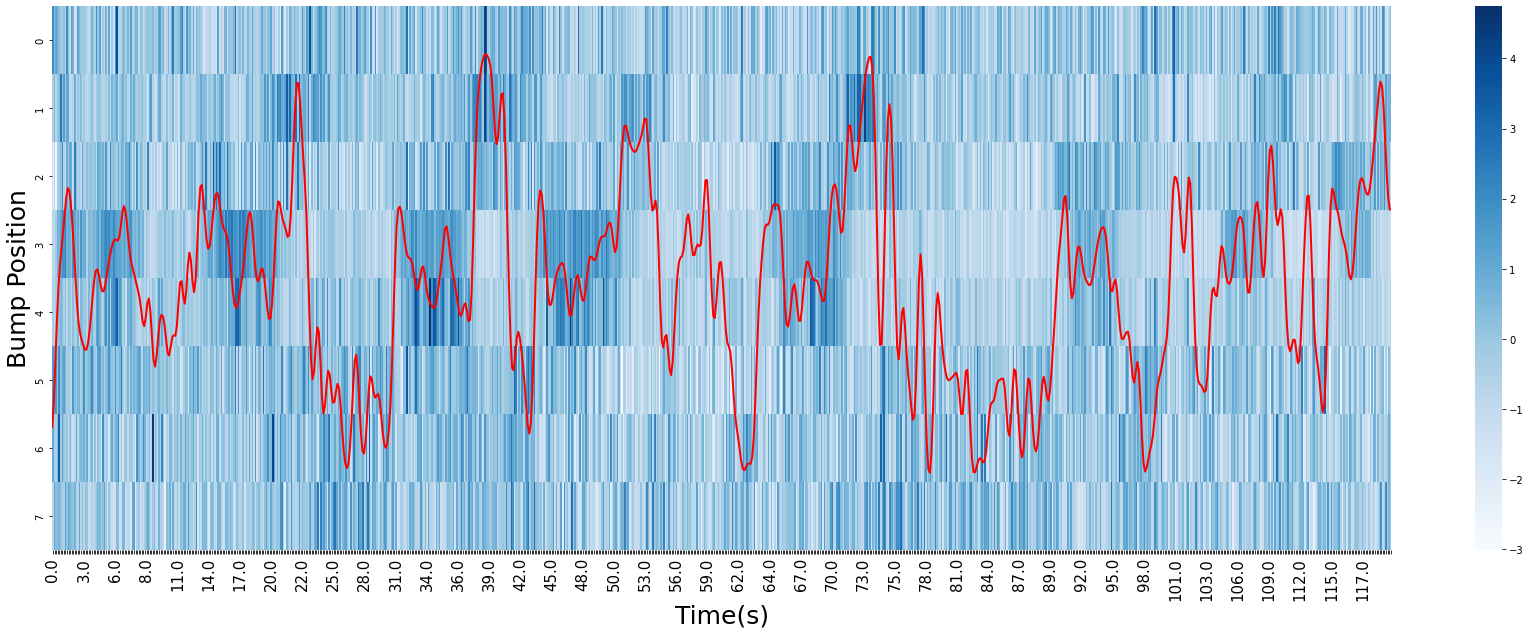

In [430]:
#Plot heatmap of signals in combined ROI and superimpose with PVA calculated from z score (right only)
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
z_in_ROI_right_only = pd.DataFrame(z_8_roi_right_only.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(z_in_ROI_right_only , cmap='Blues', xticklabels = time_array_imaging_round)
p1.set_xticklabels(p1.get_xticklabels(), size =15)
sns.color_palette("light:b", as_cmap=True)
for index, label in enumerate(p1.get_xticklabels()):
    if index % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
# + 0.5 to put the PVA line in the middle
#p2 = sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_z, sigma = 2)+0.5, color='red', linewidth =2)
#p2 = sns.lineplot(data = low_pass_filter_TQ(PVA_ROI_assigned_z, lowPassCutoff = 0.5, sampleRate = volume_rate )+0.5, color='red', linewidth =2)
#plt.plot(PVA_ROI_assigned_z+0.5,color='red', linewidth =2)
sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_z_right_only, sigma = 2)+0.5, color='red', linewidth =2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

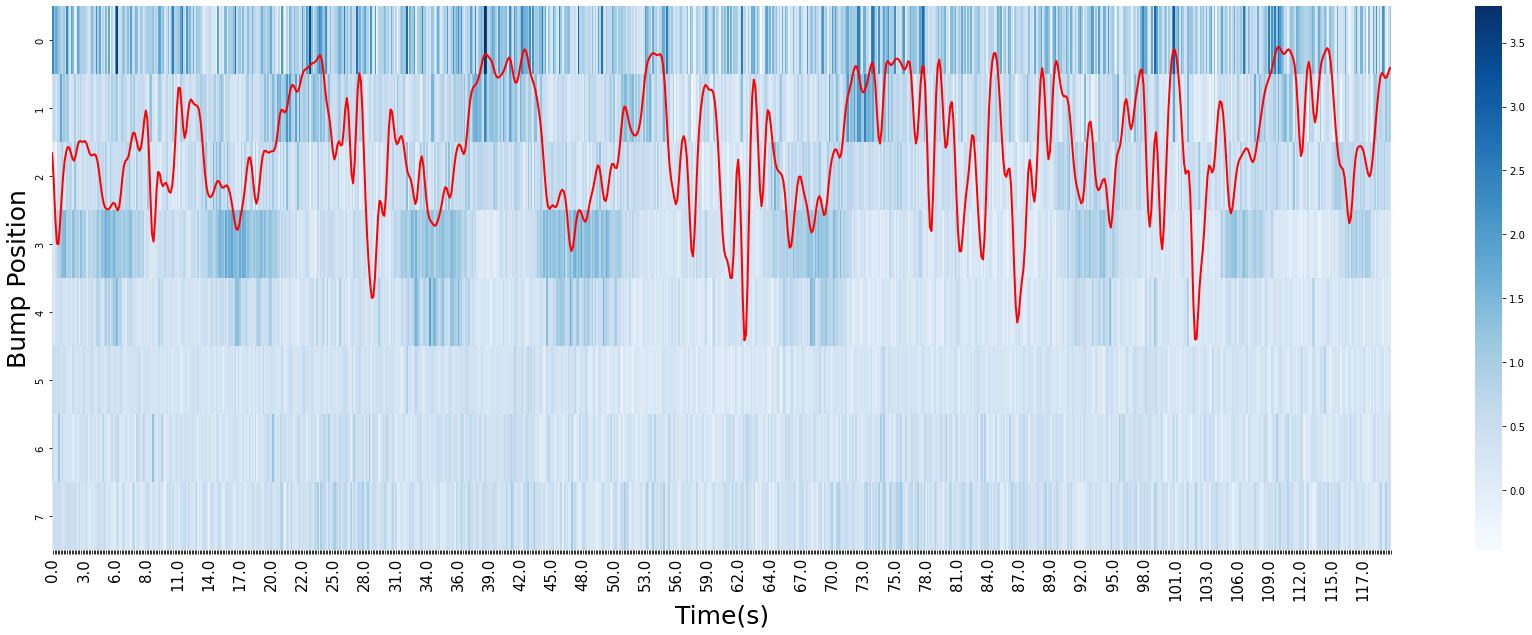

In [431]:
#Plot heatmap of signals in combined ROI and superimpose with PVA calculated from dff score (right only)
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
dF_F_in_ROI_right_only = pd.DataFrame(dF_F_8_roi_right_only.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(dF_F_in_ROI_right_only , cmap='Blues', xticklabels = time_array_imaging_round)
p1.set_xticklabels(p1.get_xticklabels(), size =15)
sns.color_palette("light:b", as_cmap=True)
for index, label in enumerate(p1.get_xticklabels()):
    if index % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
# + 0.5 to put the PVA line in the middle
#p2 = sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_z, sigma = 2)+0.5, color='red', linewidth =2)
#p2 = sns.lineplot(data = low_pass_filter_TQ(PVA_ROI_assigned_z, lowPassCutoff = 0.5, sampleRate = volume_rate )+0.5, color='red', linewidth =2)
#plt.plot(PVA_ROI_assigned_z+0.5,color='red', linewidth =2)
sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_dff_right_only, sigma = 2)+ 0.5, color='red', linewidth =2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

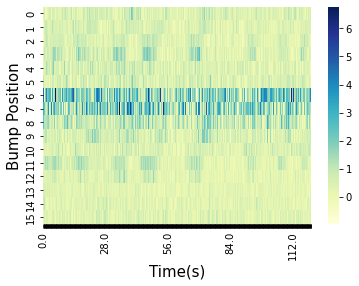

In [393]:
#Plot uncombined 16 ROi all together
p16 = sns.heatmap(dF_F_array.transpose(),cmap='YlGnBu', xticklabels = time_array_imaging_round)
p16.set_xticklabels(p16.get_xticklabels(), size =10)
sns.color_palette("light:b", as_cmap=True)
for index, label in enumerate(p16.get_xticklabels()):
    if index % 200 == 0:
        label.set_visible(True)
    elif index == max(enumerate(p16.get_xticklabels()))[0]:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xlabel('Time(s)', fontsize=15)
plt.ylabel('Bump Position', fontsize=15)
plt.show()

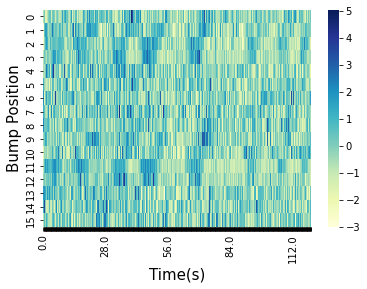

In [394]:
#Plot uncombined 16 ROi all together (z-score)
p16 = sns.heatmap(Z_score_array.transpose(),cmap='YlGnBu', xticklabels = time_array_imaging_round)
p16.set_xticklabels(p16.get_xticklabels(), size =10)
sns.color_palette("light:b", as_cmap=True)
for index, label in enumerate(p16.get_xticklabels()):
    if index % 200 == 0:
        label.set_visible(True)
    elif index == max(enumerate(p16.get_xticklabels()))[0]:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xlabel('Time(s)', fontsize=15)
plt.ylabel('Bump Position', fontsize=15)
plt.show()

In [395]:
voltage_recording = pd.read_csv('/home/tianhaoqiu/Desktop/TSeries-11032022-1411-003/TSeries-11032022-1411-003_Cycle00001_VoltageRecording_001.csv')

In [396]:
voltage_recording 

Time(ms)   Input 0   Input 1   Input 2   Input 3   Input 4  \
0              0.000  0.022278  0.017395  0.054626  0.016174  4.532776   
1              0.005  0.019531  0.015869  0.053101  0.015869  4.533691   
2              0.010  0.020142  0.016785  0.054626  0.016479  4.533386   
3              0.015  0.020752  0.017090  0.053101  0.016785  4.533997   
4              0.020  0.022888  0.019836  0.056763  0.019531  4.533997   
...              ...       ...       ...       ...       ...       ...   
24016996  120084.980  0.020142  0.016479  0.058289  0.016479  7.015686   
24016997  120084.985  0.021057  0.018921  0.054016  0.016174  7.016296   
24016998  120084.990  0.018921  0.015259  0.057678  0.015259  7.016296   
24016999  120084.995  0.019531  0.015259  0.051575  0.015869  7.016296   
24017000  120085.000  0.019531  0.016479  0.057983  0.015869  7.016296   

           Input 5   Input 6   Input 7  
0         3.106995  9.999695 -0.004578  
1         3.107300  9.999695 -0.004578  
2         3.107300  9.999695 -0.005188  
3         3.107300  9.999695 -0.004578  
4         3.106995  9.999695 -0.003967  
...            ...       ...       ...  
24016996  3.106079  9.999695 -0.005188  
24016997  3.105469  9.999695 -0.005188  
24016998  3.106689  9.999695 -0.004272  
24016999  3.107605  9.999695 -0.004272  
24017000  3.107605  9.999695 -0.006714  

[24017001 rows x 9 columns]

In [397]:
#Input5 = Heading, Input6 =x , Input7 =y

In [398]:
voltage_recording = voltage_recording.rename(columns={"Time(ms)":"time_ms", " Input 4": "Heading", " Input 6": "x_position", " Input 7": "y_position"})
voltage_recording 

time_ms   Input 0   Input 1   Input 2   Input 3   Heading  \
0              0.000  0.022278  0.017395  0.054626  0.016174  4.532776   
1              0.005  0.019531  0.015869  0.053101  0.015869  4.533691   
2              0.010  0.020142  0.016785  0.054626  0.016479  4.533386   
3              0.015  0.020752  0.017090  0.053101  0.016785  4.533997   
4              0.020  0.022888  0.019836  0.056763  0.019531  4.533997   
...              ...       ...       ...       ...       ...       ...   
24016996  120084.980  0.020142  0.016479  0.058289  0.016479  7.015686   
24016997  120084.985  0.021057  0.018921  0.054016  0.016174  7.016296   
24016998  120084.990  0.018921  0.015259  0.057678  0.015259  7.016296   
24016999  120084.995  0.019531  0.015259  0.051575  0.015869  7.016296   
24017000  120085.000  0.019531  0.016479  0.057983  0.015869  7.016296   

           Input 5  x_position  y_position  
0         3.106995    9.999695   -0.004578  
1         3.107300    9.999695   -0.004578  
2         3.107300    9.999695   -0.005188  
3         3.107300    9.999695   -0.004578  
4         3.106995    9.999695   -0.003967  
...            ...         ...         ...  
24016996  3.106079    9.999695   -0.005188  
24016997  3.105469    9.999695   -0.005188  
24016998  3.106689    9.999695   -0.004272  
24016999  3.107605    9.999695   -0.004272  
24017000  3.107605    9.999695   -0.006714  

[24017001 rows x 9 columns]

In [399]:
heading_array = voltage_recording ['Heading']
x_movement_array = voltage_recording ['x_position']
y_movement_array = voltage_recording ['y_position']
time_array_initial_fictrac = np.arange(len(heading_array))/fictrack_sampling_rate

In [400]:
time_array_initial_fictrac

array([0.00000000e+00, 5.00000000e-06, 1.00000000e-05, ...,
       1.20084990e+02, 1.20084995e+02, 1.20085000e+02])

Text(0, 0.5, 'Voltage')

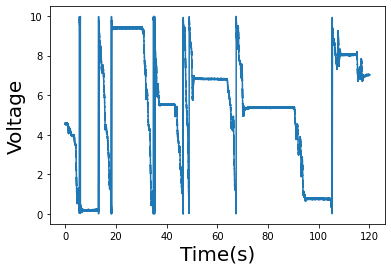

In [401]:
plt.plot(time_array_initial_fictrac,heading_array)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Voltage', fontsize=20)

In [402]:
#Downsampling the heading_array to the 2p volume rate
def downsample_heading_to_total_volume(cycle_number,heading_array_initial):
    from scipy.interpolate import interp1d
    cycle_num = cycle_number
    #Generate  a function based on initial heading arrat to use interpolation to find the value of new points.
    interpolated = interp1d(np.arange(len(heading_array_initial)), heading_array_initial, axis = 0, fill_value = 'extrapolate') 
    downsampled = interpolated(np.linspace(0,len(heading_array_initial), cycle_num))
    
    return downsampled


Text(0, 0.5, 'Voltage')

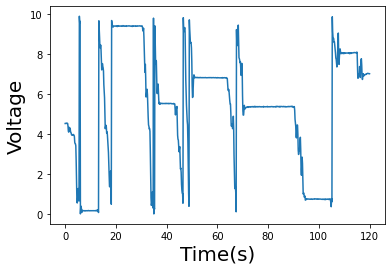

In [403]:
head_array_downsampled = downsample_heading_to_total_volume(volume_cycle, heading_array)
plt.plot(time_array_imaging,head_array_downsampled)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Voltage', fontsize=20)

Text(0, 0.5, 'Voltage')

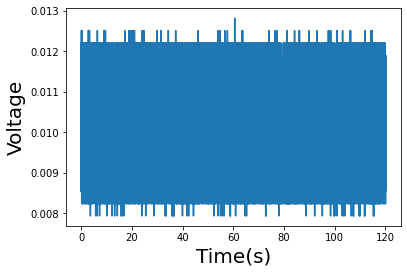

In [76]:
plt.plot(time_array_initial_fictrac,x_movement_array)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Voltage', fontsize=20)

Text(0, 0.5, 'Voltage')

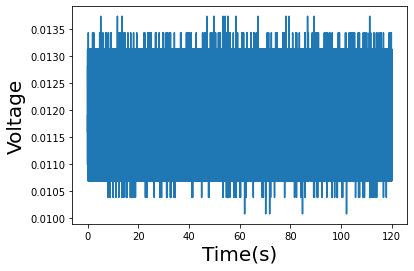

In [49]:
plt.plot(time_array_initial_fictrac,y_movement_array)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Voltage', fontsize=20)

In [404]:
def fictrack_signal_decoding(unprocessed_heading, time_array, max_voltage, already_radian):
    #Prepocessing the heading array for further analysis
    if already_radian == False:
        RadiansArray_heading = unprocessed_heading * np.pi * 2 / max_voltage
    else:
        RadiansArray_heading = unprocessed_heading
    unwrapped_heading = np.unwrap(RadiansArray_heading)
    nanIDX =[]
    #Find where is the big jump happening 
    upwrappedIndexes  = np.argwhere(np.absolute(np.diff(RadiansArray_heading)) > np.pi)
    NUM_SAMPLES_FROM_WRAP_TO_REPLACE = 2
    
    for i in range(len(upwrappedIndexes)):
        if upwrappedIndexes[i] < (NUM_SAMPLES_FROM_WRAP_TO_REPLACE -1) and upwrappedIndexes[i] > len(unwrapped_heading) - (NUM_SAMPLES_FROM_WRAP_TO_REPLACE+1):
            upwrappedIndexes.pop(i)
            i = i - 1
    
    #Repplace potentially problematic indexs with NaN
    cleanedPos = unwrapped_heading
    for j in range(len(upwrappedIndexes)):
        index_start = upwrappedIndexes[j] - NUM_SAMPLES_FROM_WRAP_TO_REPLACE 
        index_end = upwrappedIndexes[j] + NUM_SAMPLES_FROM_WRAP_TO_REPLACE 
        cleanedPos[index_start[0]-1:index_end[0]] = np.NaN
        
    #Replace NaN values with the last preceding value that was a real number
    nanIDX = np.argwhere(np.isnan(cleanedPos))
    
    while (len(nanIDX) > 0):
        cleanedPos[nanIDX] = cleanedPos[nanIDX-1]
        nanIDX = np.argwhere(np.isnan(cleanedPos))
    
    cleanedPos = np.absolute(cleanedPos)
    
    plt.plot(time_array, cleanedPos)
    plt.xlabel('Time(s)', fontsize=20)
    plt.ylabel('Accumulated rotation (rad)', fontsize=20)
    plt.show()
    
    return cleanedPos

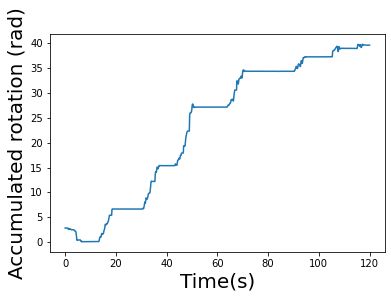

In [405]:
max_Voltage = 10
heading_array_processed = fictrack_signal_decoding(head_array_downsampled, time_array_imaging, max_Voltage, already_radian = False)

In [269]:
#lowpasfilter heading array
#heading_array_processed = low_pass_filter_TQ(heading_array_processed, lowPassCutoff = 1, sampleRate = volume_rate)
#plt.plot(time_array_imaging ,heading_array_processed)
#plt.xlabel('Time(s)', fontsize=20)
#plt.ylabel('Accumulated rotation (rad)', fontsize=20)
#plt.show()

In [270]:
#x_movement_array_processed = fictrack_signal_decoding(x_movement_array, time_array_initial_fictrac)

In [272]:
#x_movement_array_processed = low_pass_filter_TQ(x_movement_array_processed , lowPassCutoff = 90, sampleRate = fictrack_sampling_rate)
#plt.plot(time_array_initial_fictrac ,x_movement_array_processed)
#plt.xlabel('Time(s)', fontsize=20)
#plt.ylabel('Accumulated rotation (rad)', fontsize=20)
#plt.show()

In [271]:
#y_movement_array_processed = fictrack_signal_decoding(y_movement_array, time_array_initial_fictrac)

In [273]:
#y_movement_array_processed = low_pass_filter_TQ(y_movement_array_processed , lowPassCutoff = 90, sampleRate = fictrack_sampling_rate)
#plt.plot(time_array_initial_fictrac ,y_movement_array_processed)
#plt.xlabel('Time(s)', fontsize=20)
#plt.ylabel('Accumulated rotation (rad)', fontsize=20)
#plt.show()

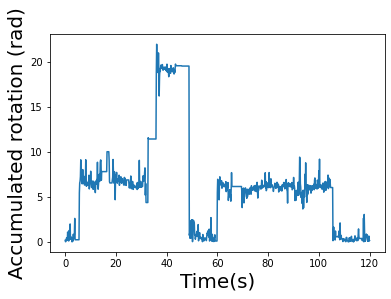

In [406]:
PVA_unwrapped = fictrack_signal_decoding(PVA_radian_array, time_array_imaging, max_voltage = 10, already_radian = True)

In [279]:
#lowpasfilter PVA array
#PVA_unwrapped = low_pass_filter_TQ(PVA_unwrapped, lowPassCutoff = 1, sampleRate = volume_rate)
#plt.plot(time_array_imaging, PVA_unwrapped)
#plt.xlabel('Time(s)', fontsize=20)
#plt.ylabel('Accumulated rotation (rad)', fontsize=20)
#plt.show()

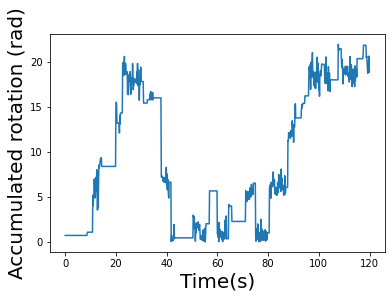

In [407]:
PVA_unwrapped_z = fictrack_signal_decoding(PVA_radian_array_z, time_array_imaging,max_voltage = 10, already_radian = True)
#PVA_unwrapped_z = low_pass_filter_TQ(PVA_unwrapped_z, lowPassCutoff = 1, sampleRate = volume_rate)

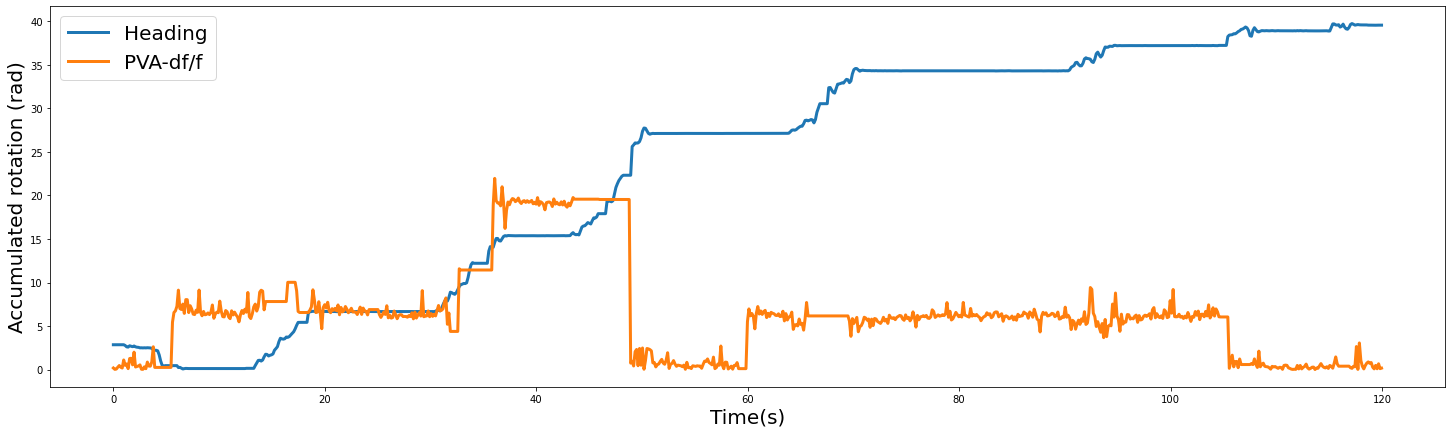

In [408]:
#head_array_downsampled = downsample_heading_to_total_volume(volume_cycle, heading_array_processed)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped,linewidth =3)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Accumulated rotation (rad)', fontsize=20)
plt.legend(['Heading','PVA-df/f'],fontsize=20)
plt.show()

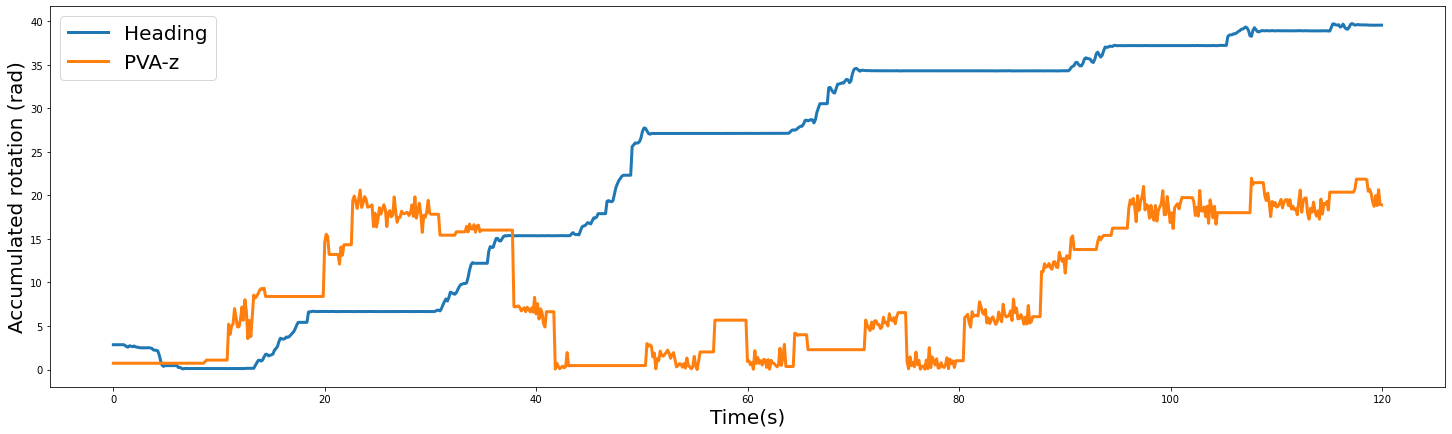

In [409]:
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped_z,linewidth =3)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Accumulated rotation (rad)', fontsize=20)
plt.legend(['Heading','PVA-z'],fontsize=20)
plt.show()

In [410]:
#just for the case that voltage recording stopped early 
#total_fictrack_time = len(heading_array_processed)/fictrack_sampling_rate
#shortened_cycle_number = np.int_(np.round(total_fictrack_time/volume_time))
#shortened_cycle_number
#time_array_short = np.arange(shortened_cycle_number)/volume_rate
#head_array_downsampled_short = downsample_heading_to_total_volume(shortened_cycle_number, heading_array_processed)
#plt.figure(figsize= (25,7))
#plt.plot(time_array_short, head_array_downsampled_short,linewidth =3)
#plt.plot(time_array_short, PVA_unwrapped[0:shortened_cycle_number],linewidth =3)
#plt.xlabel('Time(s)', fontsize=20)
#plt.ylabel('Accumulated rotation (rad)', fontsize=20)
#plt.legend(['Heading','PVA'],fontsize=20)
#plt.show()

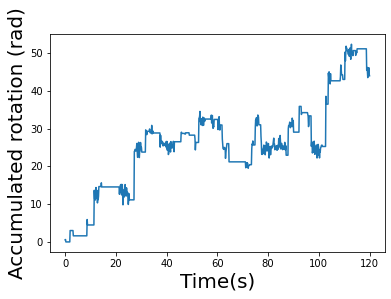

In [432]:
PVA_unwrapped_z_left_only = fictrack_signal_decoding(PVA_radian_array_z_left_only, time_array_imaging,max_voltage = 10, already_radian = True)
#PVA_unwrapped_z_left_only = low_pass_filter_TQ(PVA_unwrapped_z_left_only, lowPassCutoff = 1, sampleRate = volume_rate)

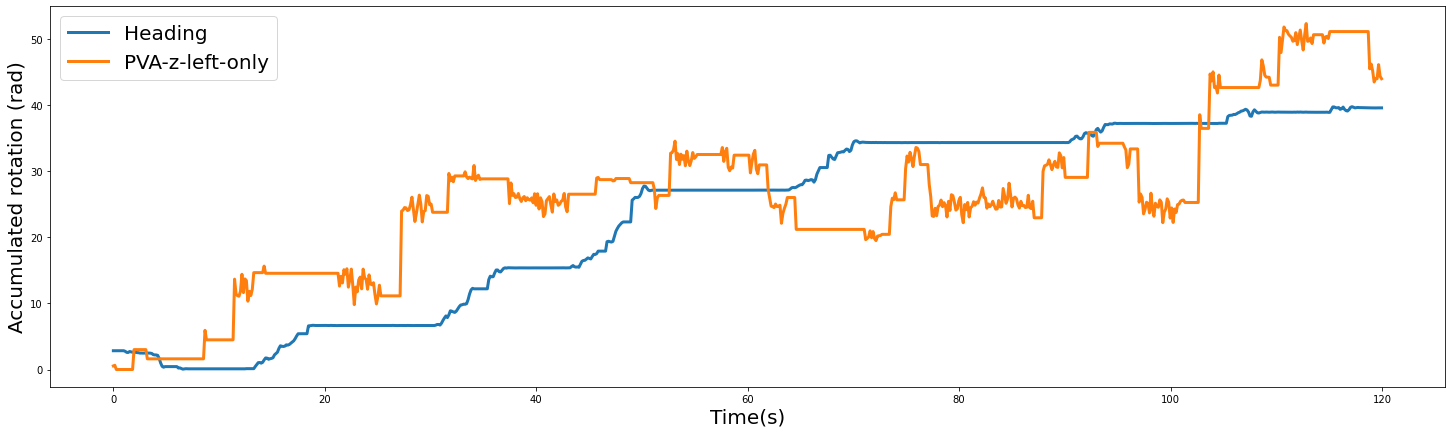

In [412]:
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped_z_left_only,linewidth =3)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Accumulated rotation (rad)', fontsize=20)
plt.legend(['Heading','PVA-z-left-only'],fontsize=20)
plt.show()

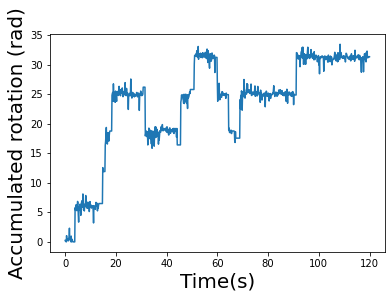

In [433]:
PVA_unwrapped_dff_left_only = fictrack_signal_decoding(PVA_radian_array_dff_left_only, time_array_imaging,max_voltage = 10, already_radian = True)
#PVA_unwrapped_z_left_only = low_pass_filter_TQ(PVA_unwrapped_z_left_only, lowPassCutoff = 1, sampleRate = volume_rate)

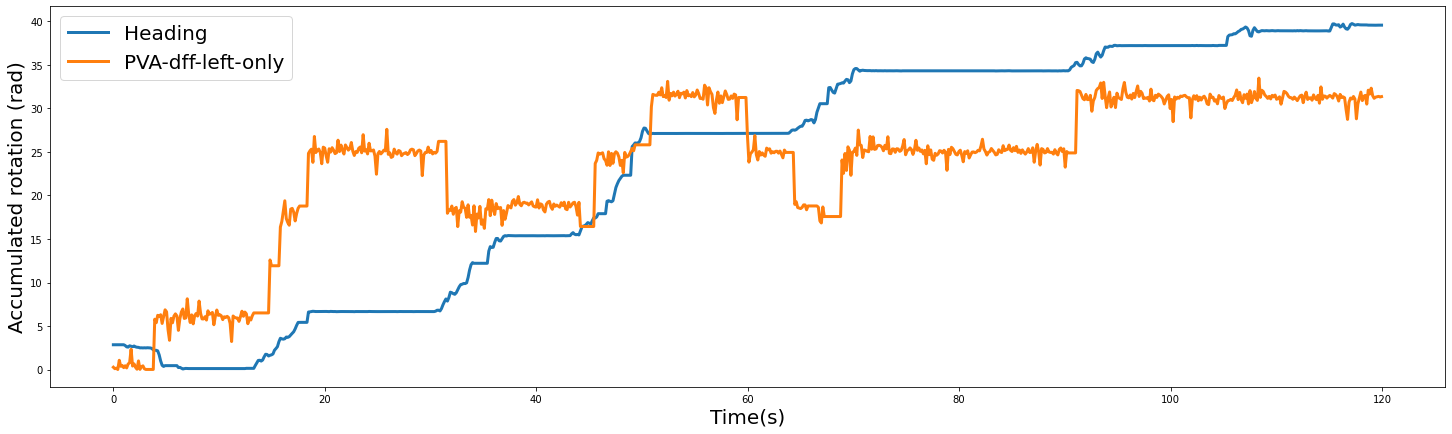

In [414]:
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped_dff_left_only,linewidth =3)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Accumulated rotation (rad)', fontsize=20)
plt.legend(['Heading','PVA-dff-left-only'],fontsize=20)
plt.show()

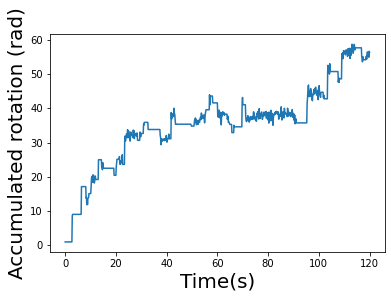

In [434]:
PVA_unwrapped_z_right_only = fictrack_signal_decoding(PVA_radian_array_z_right_only, time_array_imaging,max_voltage = 10, already_radian = True)

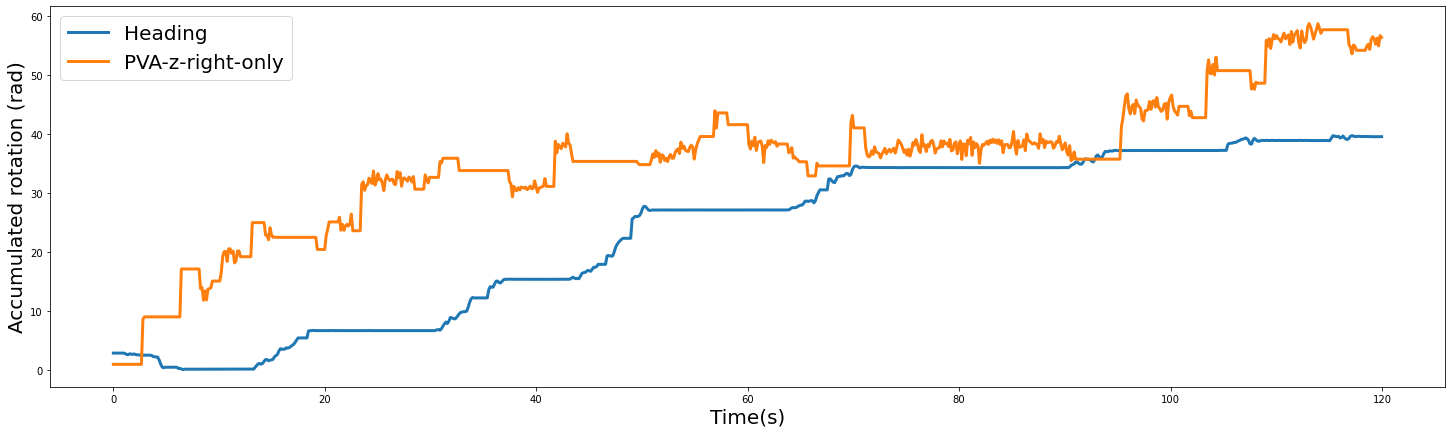

In [435]:
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped_z_right_only,linewidth =3)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Accumulated rotation (rad)', fontsize=20)
plt.legend(['Heading','PVA-z-right-only'],fontsize=20)
plt.show()

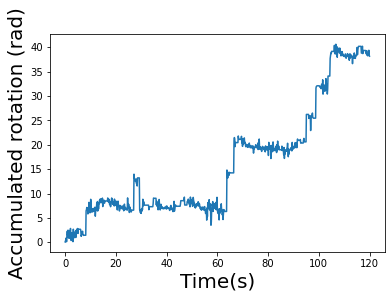

In [436]:
PVA_unwrapped_dff_right_only = fictrack_signal_decoding(PVA_radian_array_dff_right_only, time_array_imaging,max_voltage = 10, already_radian = True)

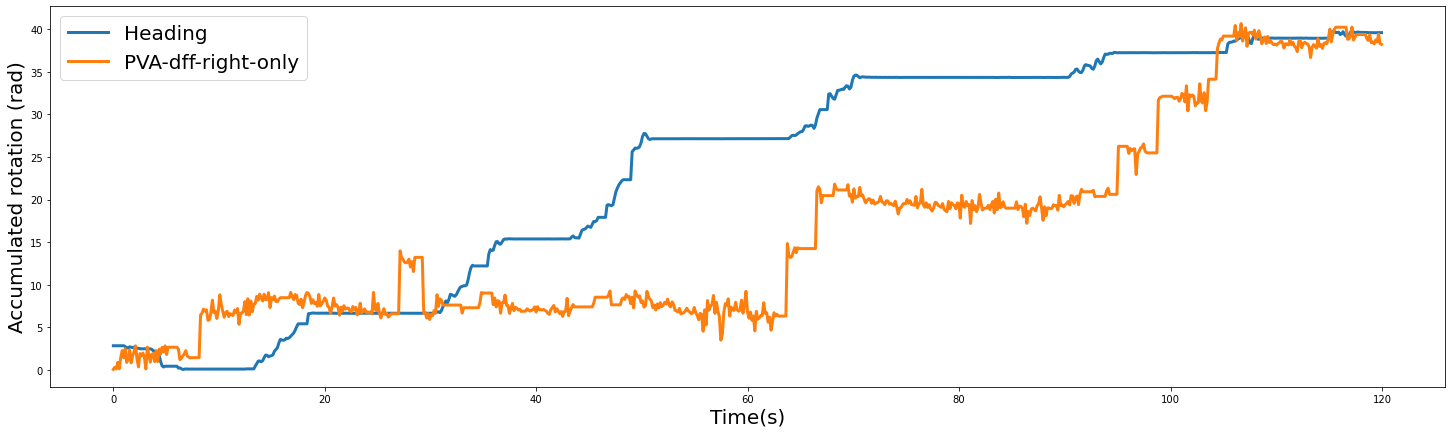

In [437]:
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped_dff_right_only,linewidth =3)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Accumulated rotation (rad)', fontsize=20)
plt.legend(['Heading','PVA-dff-right-only'],fontsize=20)
plt.show()

In [496]:
#Create a dataframe to contain all different ways calculating unwrapped PVA and/or amplitudes
all_pva_data = pd.DataFrame()
all_pva_data['Heading'] = heading_array_processed
all_pva_data['PVA_radian_dff'] = PVA_unwrapped
all_pva_data['PVA_radian_dff_left_only'] = PVA_unwrapped_dff_left_only
all_pva_data['PVA_radian_dff_right_only'] =  PVA_unwrapped_dff_right_only
all_pva_data['PVA_radian_z'] = PVA_unwrapped_z
all_pva_data['PVA_radian_z_left_only'] = PVA_unwrapped_z_left_only 
all_pva_data['PVA_radian_z_right_only'] = PVA_unwrapped_z_right_only 
all_pva_data['Bump_amplitude'] = bump_amplitude_dff
all_pva_data['Bump_amplitude_left_only'] = bump_amplitude_dff_left_only
all_pva_data['Bump_amplitude_right_only'] = bump_amplitude_dff_right_only
all_pva_data['Heading_velocity'] = np.gradient(heading_array_processed)
all_pva_data['PVA_dff_velocity'] = np.gradient(all_pva_data['PVA_radian_dff'])
all_pva_data['PVA_dff_left_only_velocity'] = np.gradient(all_pva_data['PVA_radian_dff_left_only'])
all_pva_data['PVA_dff_right_only_velocity'] = np.gradient(all_pva_data['PVA_radian_dff_right_only'])
all_pva_data['PVA_z_velocity'] = np.gradient(all_pva_data['PVA_radian_z'])
all_pva_data['PVA_z_left_only_velocity'] = np.gradient(all_pva_data['PVA_radian_z_left_only'])
all_pva_data['PVA_z_right_only_velocity'] = np.gradient(all_pva_data['PVA_radian_z_right_only'])
all_pva_data

Heading  PVA_radian_dff  PVA_radian_dff_left_only  \
0     2.848027        0.176054                  0.265724   
1     2.848632        0.020098                  0.098769   
2     2.856847        0.053587                  0.155785   
3     2.847947        0.267981                  0.004395   
4     2.851479        0.456700                  1.063356   
..         ...             ...                       ...   
854  39.564674        0.476055                 31.299654   
855  39.573061        0.089285                 31.338861   
856  39.573697        0.657962                 31.389275   
857  39.570054        0.101639                 31.319567   
858  39.573828        0.161254                 31.362773   

     PVA_radian_dff_right_only  PVA_radian_z  PVA_radian_z_left_only  \
0                     0.079951      0.722204                0.552934   
1                     0.334256      0.722204                0.642075   
2                     0.135912      0.722204                0.009980   
3                     0.903679      0.722204                0.009980   
4                     0.139317      0.722204                0.009980   
..                         ...           ...                     ...   
854                  38.713295     19.987592               44.026269   
855                  38.464993     18.837488               43.981316   
856                  39.402866     20.661203               46.111936   
857                  38.290811     18.962353               44.361725   
858                  38.192457     18.914107               43.983795   

     PVA_radian_z_right_only  Bump_amplitude  Bump_amplitude_left_only  \
0                   0.939120        2.831929                  4.959309   
1                   0.939120        1.833897                  2.806811   
2                   0.939120        1.775603                  3.866626   
3                   0.939120        1.929589                  3.430970   
4                   0.939120        1.385987                  2.550793   
..                       ...             ...                       ...   
854                55.252123        1.500405                  1.948796   
855                56.279675        1.534698                  3.088319   
856                54.969726        0.681385                  1.743483   
857                56.715219        1.655448                  4.116563   
858                56.413232        1.571953                  2.317929   

     Bump_amplitude_right_only  Heading_velocity  PVA_dff_velocity  \
0                     2.378483          0.000605         -0.155956   
1                     1.079500          0.004410         -0.061234   
2                     2.078751         -0.000343          0.123942   
3                     1.219530         -0.002684          0.201556   
4                     0.770725          0.006696         -0.003464   
..                         ...               ...               ...   
854                   1.657860          0.006615          0.006094   
855                   1.196705          0.004511          0.090954   
856                   0.895499         -0.001504          0.006177   
857                   0.901104          0.000066         -0.248354   
858                   1.116162          0.003775          0.059616   

     PVA_dff_left_only_velocity  PVA_dff_right_only_velocity  PVA_z_velocity  \
0                     -0.166955                     0.254305        0.000000   
1                     -0.054969                     0.027981        0.000000   
2                     -0.047187                     0.284712        0.000000   
3                      0.453785                     0.001702        0.000000   
4                      0.184964                     0.282278        0.000000   
..                          ...                          ...             ...   
854                    0.084820                     0.104030        0.042815   
855                    0.044811                    

<AxesSubplot:title={'center':'Turning vs PVA (z) right only'}, xlabel='PVA_z_right_only_velocity', ylabel='Heading_velocity'>

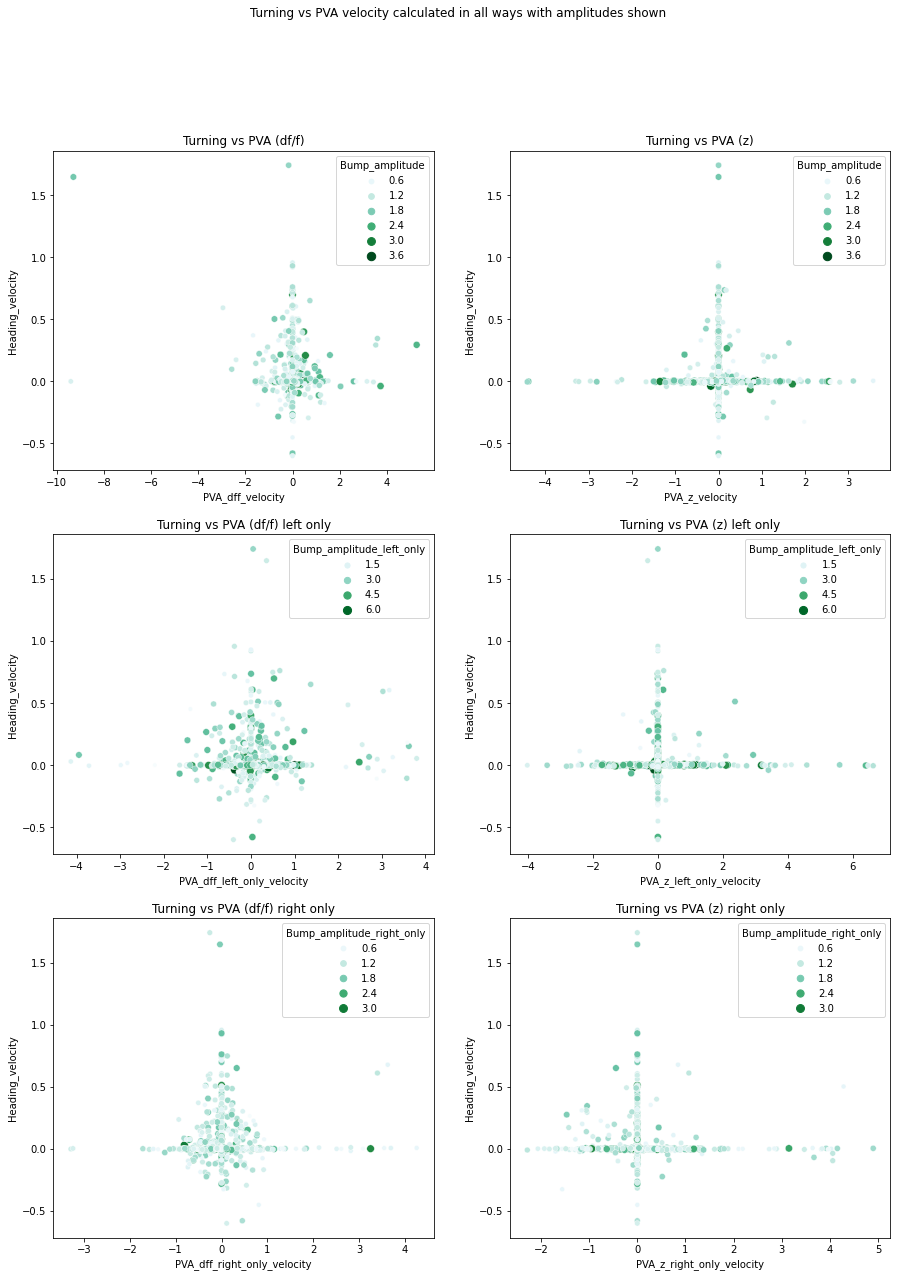

In [518]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
fig.suptitle('Turning vs PVA velocity calculated in all ways with amplitudes shown')
axs[0,0].set_title('Turning vs PVA (df/f)')
sns.scatterplot(ax = axs[0,0], data = all_pva_data, x = 'PVA_dff_velocity', y = 'Heading_velocity', hue = 'Bump_amplitude', size = 'Bump_amplitude', palette = 'BuGn')

axs[0,1].set_title('Turning vs PVA (z)')
sns.scatterplot(ax = axs[0,1], data = all_pva_data, x = 'PVA_z_velocity', y = 'Heading_velocity', hue = 'Bump_amplitude', size = 'Bump_amplitude', palette = 'BuGn')

axs[1,0].set_title('Turning vs PVA (df/f) left only')
sns.scatterplot(ax = axs[1,0], data = all_pva_data, x = 'PVA_dff_left_only_velocity', y = 'Heading_velocity', hue = 'Bump_amplitude_left_only', size = 'Bump_amplitude_left_only', palette = 'BuGn')

axs[1,1].set_title('Turning vs PVA (z) left only')
sns.scatterplot(ax = axs[1,1], data = all_pva_data, x = 'PVA_z_left_only_velocity', y = 'Heading_velocity', hue = 'Bump_amplitude_left_only', size = 'Bump_amplitude_left_only', palette = 'BuGn')

axs[2,0].set_title('Turning vs PVA (df/f) right only')
sns.scatterplot(ax = axs[2,0], data = all_pva_data, x = 'PVA_dff_right_only_velocity', y = 'Heading_velocity', hue = 'Bump_amplitude_right_only', size = 'Bump_amplitude_right_only', palette = 'BuGn')

axs[2,1].set_title('Turning vs PVA (z) right only')
sns.scatterplot(ax = axs[2,1], data = all_pva_data, x = 'PVA_z_right_only_velocity', y = 'Heading_velocity', hue = 'Bump_amplitude_right_only', size = 'Bump_amplitude_right_only', palette = 'BuGn')

In [439]:
#Calculate velocity and generate correlation matrix of PVA and Heading
def calculate_PVA_heading_velocity_corr(heading_array, PVA_array, volume_time):
    heading_velocity = np.gradient(heading_array)
    PVA_velocity = np.gradient(PVA_array)
    
    abnormal_velocity = np.argwhere(np.absolute(PVA_velocity) > np.pi)
    while (len(abnormal_velocity ) > 0):
        PVA_velocity[abnormal_velocity ] = PVA_velocity[abnormal_velocity -1]
        abnormal_velocity = np.argwhere(np.absolute(PVA_velocity) > np.pi)
    
    velocity_corr_array = np.zeros([heading_array.size, 2])
    velocity_corr_array[:,0]=heading_velocity/volume_time
    velocity_corr_array[:,1]=PVA_velocity/volume_time
    
    import seaborn as sns
    import pandas as pd
    df = pd.DataFrame(velocity_corr_array, columns = ['Turning Velocity', 'PVA Velocity'])
    sns.scatterplot(data = df, x='Turning Velocity', y='PVA Velocity')
    plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 10)
    plt.ylabel('Turning Velocity (Rad/Sec)', fontsize = 10)    
    return PVA_velocity, heading_velocity, df

-0.05879174917872325

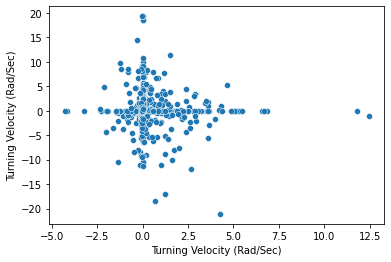

In [440]:
PVA_vel, Heading_vel, velocity_df = calculate_PVA_heading_velocity_corr(heading_array_processed, PVA_unwrapped, volume_time=volume_time)
np.corrcoef(PVA_vel,Heading_vel)[0,1]

In [441]:
def shift_for_maximum_correlation(x, y, max_shift_frame):
    
    from scipy.signal import correlate
    from scipy.signal import correlation_lags

    correlation = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
                                  
    #find the middle index to consider the frame on both side till max shift frame (1s)
    middle_index = int(len(lags)/2)
    lags_short = lags[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
    correlation_short = correlation[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
    lag = lags_short[np.argmax(np.abs(correlation_short))]
    if lag < 0:
        y = y.iloc[abs(lag):].reset_index(drop=True)
    else:
        x = x.iloc[lag:].reset_index(drop=True)
    return x, y, lag

Text(0.5, 1.0, 'Correlation after shifting,lag equals 0.97853 s, R = -0.08176072969328238')

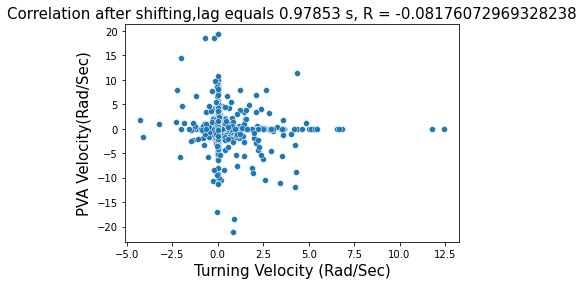

In [442]:
shifted_x, shifted_y, lagframe = shift_for_maximum_correlation(velocity_df['Turning Velocity'], velocity_df['PVA Velocity'], max_shift_frame = round(volume_rate))
shortest = min(shifted_x.shape[0], shifted_y.shape[0])
np.corrcoef(shifted_x.iloc[:shortest].values, shifted_y.iloc[:shortest].values)[0, 1]
velocity_crosscorrelated = pd.concat([shifted_x.iloc[:shortest], shifted_y.iloc[:shortest]], axis=1, join='inner')
import seaborn as sns
sns.scatterplot(data = velocity_crosscorrelated, x='Turning Velocity', y='PVA Velocity')
plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 15)
plt.ylabel('PVA Velocity(Rad/Sec)', fontsize = 15)  
plt.title(f"Correlation after shifting,lag equals {np.abs(lagframe) * volume_time} s, R = {np.corrcoef(shifted_x.iloc[:shortest].values, shifted_y.iloc[:shortest].values)[0, 1]}", fontsize = 15)

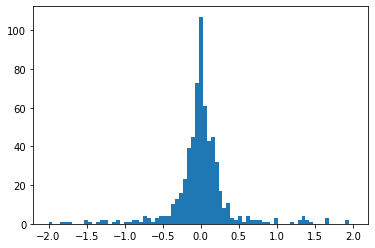

In [443]:
Heading_vel_degree = Heading_vel * 180/np.pi
plt.hist(Heading_vel_degree, bins='auto', range = (-2,2))
plt.show()

In [444]:
np.quantile(np.abs(Heading_vel_degree),0.95)

21.12207436727862

In [445]:
# using the downsampled heading array to find the period when fly stop walking 
def find_persistence_period(head_array, degree_of_tolerance, shortest_stopFrame):
    #Convert tolerance to radian since heading array is in radians
    radian_tol = degree_of_tolerance * np.pi/180
    
    persistenceArray = np.zeros(head_array.size)
    for current_frame in range(1,len(head_array)):
        head_current = head_array[current_frame]
        
        previous_bar_positions = head_array[0:current_frame]
        #Absolute value of different from current heading
        absDiffFromCurrent = np.abs(previous_bar_positions - head_current)
        
        aboveThresholdIndex = np.argwhere(absDiffFromCurrent > radian_tol)
        
        if len(aboveThresholdIndex) == 0:
            persistenceArray[current_frame] = current_frame - 1
        else:
            mostRecentAboveThreshold = np.max(aboveThresholdIndex)
            persistenceArray[current_frame] = current_frame - mostRecentAboveThreshold 
       

    return persistenceArray


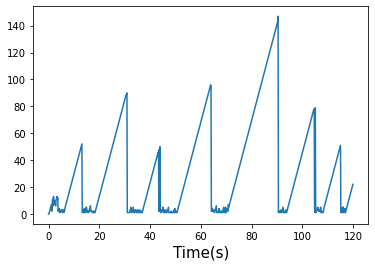

In [446]:
persistence_Array = find_persistence_period(head_array_downsampled,degree_of_tolerance = 20,shortest_stopFrame = 25)
plt.plot(time_array_imaging, persistence_Array)
plt.xlabel('Time(s)', fontsize = 15)
plt.show()

In [447]:
def find_stop_period_on_heading(head_velocity_array,degree_of_tolerance,shortest_stopFrame):
    radian_cutoff = degree_of_tolerance * np.pi/180
    stop_index = []
    stop_length = []
    count = 0
    
    for current_volume in range(len(head_velocity_array)):
        #Special case for last index in the array
        if current_volume == len(head_velocity_array) -1:
            if np.abs(head_velocity_array[current_volume]) < radian_cutoff:
                count = count + 1
                if count >= shortest_stopFrame:
                    stop_index.append(current_volume)
                    stop_length.append(count)
            elif count >= shortest_stopFrame:
                stop_index.append(current_volume-1)
                stop_length.append(count)               
        elif current_volume < len(head_velocity_array) -1:
            if np.abs(head_velocity_array[current_volume]) < radian_cutoff:
                count = count + 1
            elif count < shortest_stopFrame:
                count = 1
            else:
                stop_index.append(current_volume-1)
                stop_length.append(count)
                count = 1
    
    stop_index_length_combined = np.zeros((len(stop_index),2))
    stop_index_length_combined[:,0] = stop_index
    stop_index_length_combined[:,1] = stop_length
    stop_index_length_combined = stop_index_length_combined.astype(int)
    return stop_index_length_combined
        

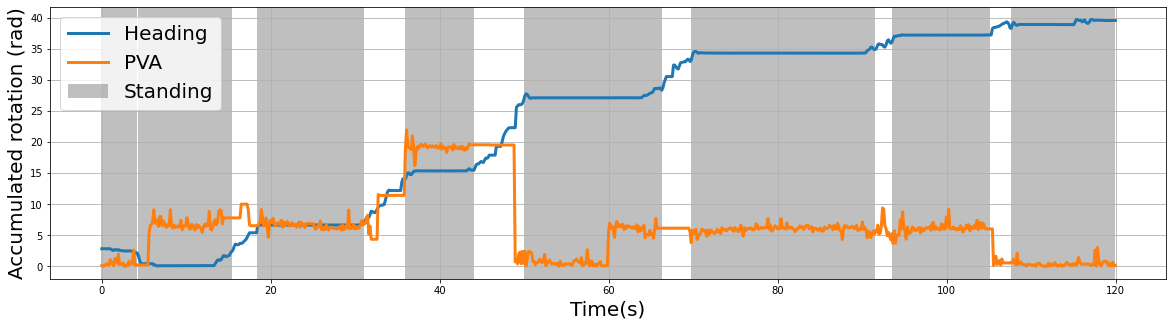

In [449]:
persistence_stop_index_and_length = find_stop_period_on_heading(Heading_vel,degree_of_tolerance =21,shortest_stopFrame=25)
plt.figure(figsize= (20,5))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped,linewidth =3)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Accumulated rotation (rad)', fontsize=20)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.legend(['Heading','PVA','Standing'],fontsize=20)
plt.grid()
plt.show()

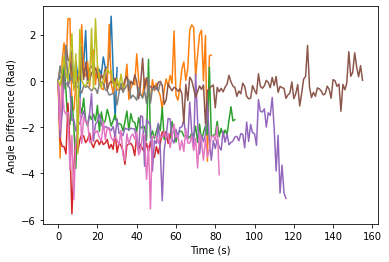

In [450]:
#Calculate annd plot difference throughout the stop period
difference_during_stop = []
for current_index in range(len(persistence_stop_index_and_length)):
    current_stop_PVA = PVA_radian_array[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
    current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
    current_difference_during_stop = PVA_radian_array[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
    difference_during_stop.append(current_difference_during_stop)
    plt.plot(current_difference_during_stop)

max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
                   
plt.ylabel('Angle Difference (Rad)')
plt.xlabel('Time (s)')
plt.show()
    
    

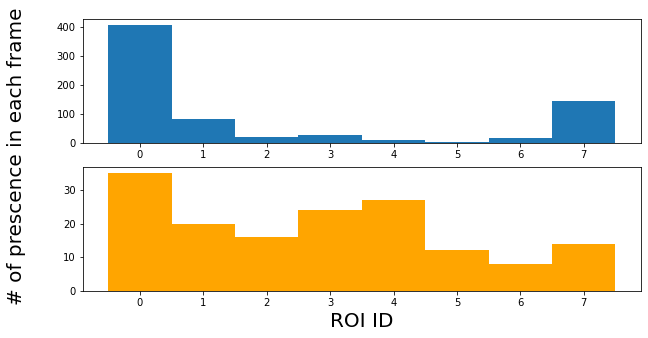

In [451]:
#Calculate bump position occupancy in the walking/stop period

#Create a mask for walking = 0, stop =1
stop_walking_state_mask = np.zeros(PVA_ROI_assigned.size)
for current_index in range(len(persistence_stop_index_and_length)):
    current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
    stop_walking_state_mask[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] = 1

mask_walking = stop_walking_state_mask == 0
mask_stop = stop_walking_state_mask == 1
bins = np.arange(0, PVA_ROI_assigned.max() + 1.5) - 0.5

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
ax = axs[0]
ax.hist(PVA_ROI_assigned[mask_stop], bins )

ax = axs[1]
ax.hist(PVA_ROI_assigned[mask_walking], bins, color = 'orange')
plt.xlabel ('ROI ID', fontsize =20)
fig.supylabel('# of prescence in each frame', fontsize =20)
plt.show()

(array([441., 100.,  36.,  50.,  37.,  15.,  24., 156.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <BarContainer object of 8 artists>)

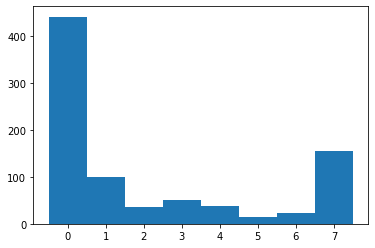

In [452]:
plt.hist(PVA_ROI_assigned, bins = np.arange(0, PVA_ROI_assigned.max() + 1.5) - 0.5)

(array([365., 137., 109.,  76., 370., 126.,  38., 172.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <BarContainer object of 8 artists>)

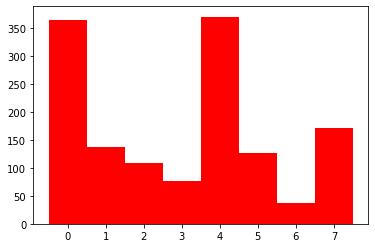

In [547]:
plt.hist(PVA_ROI_assigned_z, bins = np.arange(0, PVA_ROI_assigned.max() + 1.5) - 0.5, color ='red')

In [62]:
def PVA_during_stopPeriod(stop_index_array,PVA_array, volume_time):
    #Initiate output dataframe and 
    df_PVA_stop = pd.DataFrame()
    stop_points = []
    restart_points = []
    restart_points_100ms_before = []
    restart_points_500ms_before = []
    restart_points_2s_before = []
    frame_100ms_before = int(np.ceil(0.1/volume_time))
    frame_500ms_before = int(np.ceil(0.5/volume_time))
    frame_2s_before = int(np.ceil(2/volume_time))
    
    
    for current_index in range(len(stop_index_array)):
        restart_points.append(PVA_array[stop_index_array[current_index,0]])
        stop_points.append(PVA_array[stop_index_array[current_index,0]-stop_index_array[current_index,1]+1])
        restart_points_100ms_before.append(PVA_array[stop_index_array[current_index,0]-frame_100ms_before+1])
        restart_points_500ms_before.append(PVA_array[stop_index_array[current_index,0]-frame_500ms_before+1])
        restart_points_2s_before.append(PVA_array[stop_index_array[current_index,0]-frame_2s_before+1])
    
    
    df_PVA_stop['PVA_before_stop'] = stop_points
    df_PVA_stop['PVA_at_restart'] = restart_points
    df_PVA_stop['PVA_100ms_before_restart'] = restart_points_100ms_before
    df_PVA_stop['PVA_500ms_before_restart'] = restart_points_500ms_before
    df_PVA_stop['PVA_2s_before_restart'] = restart_points_2s_before
    return df_PVA_stop 

In [392]:
PVA_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_radian_array, volume_time=volume_time)
PVA_at_stop.insert(0,'FlyTrial','TSeries-08122022-1422-009')
PVA_at_stop.insert(1,'Genotype','R60D05>GCaMP8m')

In [393]:
PVA_at_stop

FlyTrial        Genotype  PVA_before_stop  PVA_at_restart  \
0  TSeries-08122022-1422-009  R60D05>GCaMP8m         1.093183        0.041748   
1  TSeries-08122022-1422-009  R60D05>GCaMP8m         3.130769        2.197156   
2  TSeries-08122022-1422-009  R60D05>GCaMP8m        -0.872778        1.515781   
3  TSeries-08122022-1422-009  R60D05>GCaMP8m         1.475453        0.538544   
4  TSeries-08122022-1422-009  R60D05>GCaMP8m         0.180411        1.276232   

   PVA_100ms_before_restart  PVA_500ms_before_restart  PVA_2s_before_restart  
0                  0.200124                  0.363931              -0.131844  
1                  1.932432                  1.658476              -0.275769  
2                  1.276947                  1.199367              -0.966389  
3                  0.373886                  1.166455              -0.804153  
4                  1.154059                  1.051691              -0.563006

In [163]:
PVA_at_stop.to_csv('PVA_5',encoding = 'utf-8', index=False)

In [165]:
PVA1 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/PVA_1')
PVA2 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/PVA_2')
PVA3 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/PVA_3')
PVA4 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/PVA_4')
PVA5 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/PVA_5')
PVA_combined = pd.concat([PVA1,PVA2,PVA3,PVA4,PVA5], ignore_index=True) 
PVA_combined

FlyTrial        Genotype  PVA_before_stop  \
0   TSeries-07052022-1251-279  R60D05>GCaMP8m         0.143843   
1   TSeries-07052022-1251-279  R60D05>GCaMP8m         2.368244   
2   TSeries-07052022-1251-279  R60D05>GCaMP8m         2.923354   
3   TSeries-07052022-1251-279  R60D05>GCaMP8m        -0.065602   
4   TSeries-07052022-1251-280  R60D05>GCaMP8m        -1.079815   
5   TSeries-07052022-1251-282  R60D05>GCaMP8m        -1.378198   
6   TSeries-07052022-1251-282  R60D05>GCaMP8m         0.537842   
7   TSeries-07052022-1251-282  R60D05>GCaMP8m        -1.246243   
8   TSeries-07052022-1251-282  R60D05>GCaMP8m         0.514507   
9   TSeries-07052022-1251-282  R60D05>GCaMP8m        -1.892453   
10  TSeries-07052022-1251-283  R60D05>GCaMP8m        -2.010791   
11  TSeries-07052022-1251-283  R60D05>GCaMP8m        -1.452345   
12  TSeries-08122022-1422-009  R60D05>GCaMP8m         1.276232   
13  TSeries-08122022-1422-009  R60D05>GCaMP8m        -2.671010   
14  TSeries-08122022-1422-009  R60D05>GCaMP8m        -0.851377   
15  TSeries-08122022-1422-009  R60D05>GCaMP8m         1.539227   
16  TSeries-08122022-1422-009  R60D05>GCaMP8m         0.619807   

    PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart  \
0        -1.018346                 -1.513543                 -0.558649   
1        -0.011672                 -0.934501                 -0.485756   
2         2.570232                  2.498203                  3.018213   
3         1.888200                  2.124569                  2.413385   
4        -1.079815                 -2.484411                 -0.415910   
5         0.227685                 -0.278748                 -0.472391   
6        -0.582138                 -1.009205                 -0.802067   
7         1.800643                  0.354052                 -2.836606   
8         2.986680                 -1.454730                 -2.362299   
9        -1.378198                 -1.201571                 -0.895514   
10       -1.087892                 -1.037549                 -1.725068   
11       -2.010791                 -1.445032                 -1.713156   
12        0.041748                  0.566830                  0.103555   
13        2.197156                  1.815461                  1.440246   
14        1.515781                  1.332891                  1.145703   
15        0.538544                  0.723854                  0.913913   
16        1.276232                  1.302728                  0.894629   

    PVA_2s_before_restart  
0               -0.304954  
1                2.554651  
2                2.748021  
3               -2.466481  
4               -1.425191  
5               -0.065425  
6               -0.697238  
7                0.554804  
8               -1.039141  
9               -0.670777  
10              -1.419722  
11              -0.329486  
12               0.145041  
13              -0.522756  
14              -0.875035  
15              -0.560350  
16              -0.640841

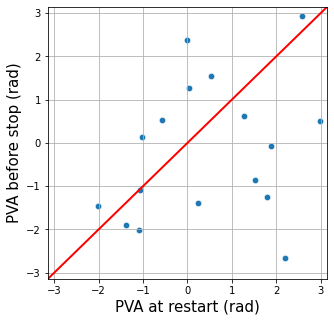

In [166]:
plt.figure(figsize= (5,5))
sns.scatterplot(data = PVA_combined, x='PVA_at_restart', y='PVA_before_stop', s=40)
X_plot = np.linspace(-np.pi, np.pi, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)
plt.xlabel('PVA at restart (rad)',fontsize= 15)
plt.ylabel('PVA before stop (rad)',fontsize= 15)
plt.grid()
plt.show()

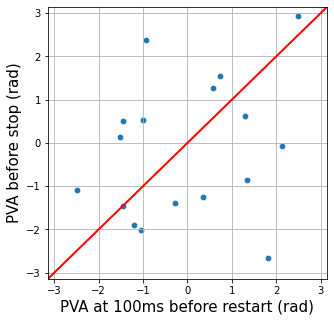

In [167]:
plt.figure(figsize= (5,5))
sns.scatterplot(data = PVA_combined, x='PVA_100ms_before_restart', y='PVA_before_stop', s=40)
X_plot = np.linspace(-np.pi, np.pi, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)
plt.xlabel('PVA at 100ms before restart (rad)', fontsize= 15)
plt.ylabel('PVA before stop (rad)',fontsize= 15)
plt.grid()
plt.show()

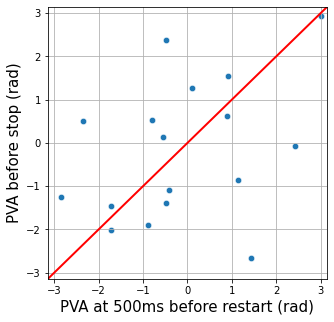

In [168]:
plt.figure(figsize= (5,5))
sns.scatterplot(data = PVA_combined, x='PVA_500ms_before_restart', y='PVA_before_stop', s=40)
X_plot = np.linspace(-np.pi, np.pi, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)
plt.xlabel('PVA at 500ms before restart (rad)', fontsize= 15)
plt.ylabel('PVA before stop (rad)',fontsize= 15)
plt.grid()
plt.show()

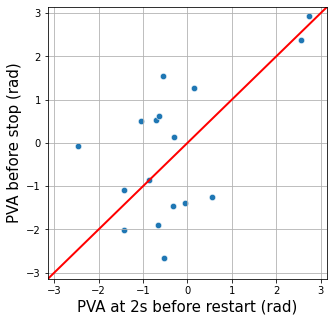

In [169]:
plt.figure(figsize= (5,5))
sns.scatterplot(data = PVA_combined, x='PVA_2s_before_restart', y='PVA_before_stop', s=40)
X_plot = np.linspace(-np.pi, np.pi, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)
plt.xlabel('PVA at 2s before restart (rad)', fontsize= 15)
plt.ylabel('PVA before stop (rad)',fontsize= 15)
plt.grid()
plt.show()

In [170]:
PVA_combined.corr(method='pearson')

PVA_before_stop  PVA_at_restart  \
PVA_before_stop                  1.000000        0.269324   
PVA_at_restart                   0.269324        1.000000   
PVA_100ms_before_restart         0.238012        0.699628   
PVA_500ms_before_restart         0.363097        0.398190   
PVA_2s_before_restart            0.574224        0.137555   

                          PVA_100ms_before_restart  PVA_500ms_before_restart  \
PVA_before_stop                           0.238012                  0.363097   
PVA_at_restart                            0.699628                  0.398190   
PVA_100ms_before_restart                  1.000000                  0.770528   
PVA_500ms_before_restart                  0.770528                  1.000000   
PVA_2s_before_restart                     0.159871                  0.102406   

                          PVA_2s_before_restart  
PVA_before_stop                        0.574224  
PVA_at_restart                         0.137555  
PVA_100ms_before_restart               0.159871  
PVA_500ms_before_restart               0.102406  
PVA_2s_before_restart                  1.000000